#### IT monitoring support data analysis

In [1]:
import pandas as pd

#### Data Preprocessing

In [2]:
df= pd.read_csv(r'C:\Users\vedant\Downloads\it_monitoring_dummy_dataset.csv')

In [3]:
df.head()

timestamp server_id  cpu_usage  memory_usage  network_in  \
0  2025-09-21 13:32:53.298515  server_1  38.205605     42.627819  220.378534   
1  2025-09-21 13:33:53.298515  server_1  34.143629     55.913979  328.611467   
2  2025-09-21 13:34:53.298515  server_1  58.814456     64.617298  167.870998   
3  2025-09-21 13:35:53.298515  server_1  41.818641     66.904956  390.638565   
4  2025-09-21 13:36:53.298515  server_1  49.550552     43.987325  110.071784   

   network_out  
0   155.392415  
1    92.834559  
2   298.336520  
3   146.481338  
4   233.822545

In [4]:
df.isnull().sum()

timestamp       0
server_id       0
cpu_usage       0
memory_usage    0
network_in      0
network_out     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100800 entries, 0 to 100799
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     100800 non-null  object 
 1   server_id     100800 non-null  object 
 2   cpu_usage     100800 non-null  float64
 3   memory_usage  100800 non-null  float64
 4   network_in    100800 non-null  float64
 5   network_out   100800 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.6+ MB


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f') 

In [7]:
df.set_index('timestamp', inplace=True)
df.dtypes

server_id        object
cpu_usage       float64
memory_usage    float64
network_in      float64
network_out     float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100800 entries, 2025-09-21 13:32:53.298515 to 2025-10-05 13:31:53.298515
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   server_id     100800 non-null  object 
 1   cpu_usage     100800 non-null  float64
 2   memory_usage  100800 non-null  float64
 3   network_in    100800 non-null  float64
 4   network_out   100800 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


###### Columns in the dataset:timestamp,server_id,cpu_usage,memory_usage,network_in,network_out
###### Frequency: 5 minute per server
###### 3 anomaly types included: sustained CPU>90%, memory-leak trend and network data spikes.

In [9]:
df.index

DatetimeIndex(['2025-09-21 13:32:53.298515', '2025-09-21 13:33:53.298515',
               '2025-09-21 13:34:53.298515', '2025-09-21 13:35:53.298515',
               '2025-09-21 13:36:53.298515', '2025-09-21 13:37:53.298515',
               '2025-09-21 13:38:53.298515', '2025-09-21 13:39:53.298515',
               '2025-09-21 13:40:53.298515', '2025-09-21 13:41:53.298515',
               ...
               '2025-10-05 13:22:53.298515', '2025-10-05 13:23:53.298515',
               '2025-10-05 13:24:53.298515', '2025-10-05 13:25:53.298515',
               '2025-10-05 13:26:53.298515', '2025-10-05 13:27:53.298515',
               '2025-10-05 13:28:53.298515', '2025-10-05 13:29:53.298515',
               '2025-10-05 13:30:53.298515', '2025-10-05 13:31:53.298515'],
              dtype='datetime64[ns]', name='timestamp', length=100800, freq=None)

In [10]:
resampled_df = (
    df.groupby('server_id')
      .resample('5min')
      .mean()
      .reset_index()
)

In [11]:
resampled_df.head()

server_id           timestamp  cpu_usage  memory_usage  network_in  \
0  server_1 2025-09-21 13:30:00  43.721230     54.386365  238.953667   
1  server_1 2025-09-21 13:35:00  46.525297     58.174213  280.639143   
2  server_1 2025-09-21 13:40:00  41.337042     58.262633  355.601771   
3  server_1 2025-09-21 13:45:00  42.590264     52.987438  235.715567   
4  server_1 2025-09-21 13:50:00  44.245519     53.709883  398.088350   

   network_out  
0   182.187831  
1   175.216650  
2   105.585471  
3   146.764014  
4   175.590833

#### Isolation Forest Model

In [12]:
from sklearn.ensemble import IsolationForest

# Example thresholds for manual anomaly detection
cpu_threshold = 90
memory_threshold = 10 # 10% increase over 30 minutes
network_threshold = 10000  # 10,000 bytes

In [13]:
resampled_df['cpu_anomaly'] = resampled_df.groupby('server_id')['cpu_usage'].apply(
    lambda x: (x > cpu_threshold).rolling(window=5).sum() >= 5
).reset_index(level=0, drop=True)

# Apply rolling window for Memory anomaly detection for each server
resampled_df['memory_anomaly'] = resampled_df.groupby('server_id')['memory_usage'].apply(
    lambda x: x.diff(6) > memory_threshold
).reset_index(level=0, drop=True)

# Apply rolling window for Network anomaly detection for each server
resampled_df['network_in_anomaly'] = resampled_df.groupby('server_id')['network_in'].apply(
    lambda x: x.diff() > network_threshold
).reset_index(level=0, drop=True)
resampled_df['network_out_anomaly'] = resampled_df.groupby('server_id')['network_out'].apply(
    lambda x: x.diff() > network_threshold
).reset_index(level=0, drop=True)

In [14]:
numeric_cols = ['cpu_usage', 'memory_usage', 'network_in', 'network_out']

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
# Initialize the Isolation Forest model


# Apply Isolation Forest to each server group
def apply_isolation_forest(group):
    scaler = StandardScaler()
     # Scale numeric features
    scaled_data = scaler.fit_transform(group[numeric_cols])
    # Fit the model and predict anomalies
    iso_forest = IsolationForest(contamination=0.01,random_state=42)  # Adjust contamination as needed
    group['anomaly'] = iso_forest.fit_predict(scaled_data)
    # -1 means anomaly, 1 means normal, convert to 'Anomaly' or 'Normal'
    group['anomaly_label'] = group['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')
    return group

# Apply the function to each group (server)
resampled_df = resampled_df.groupby('server_id').apply(apply_isolation_forest)

C:\Users\vedant\AppData\Local\Temp\ipykernel_36520\1771559797.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_df = resampled_df.groupby('server_id').apply(apply_isolation_forest)


In [15]:
resampled_df.head()

server_id           timestamp  cpu_usage  memory_usage  \
server_id                                                            
server_1  0  server_1 2025-09-21 13:30:00  43.721230     54.386365   
          1  server_1 2025-09-21 13:35:00  46.525297     58.174213   
          2  server_1 2025-09-21 13:40:00  41.337042     58.262633   
          3  server_1 2025-09-21 13:45:00  42.590264     52.987438   
          4  server_1 2025-09-21 13:50:00  44.245519     53.709883   

             network_in  network_out  cpu_anomaly  memory_anomaly  \
server_id                                                           
server_1  0  238.953667   182.187831        False           False   
          1  280.639143   175.216650        False           False   
          2  355.601771   105.585471        False           False   
          3  235.715567   146.764014        False           False   
          4  398.088350   175.590833        False           False   

             network_in_anomaly  network_out_anomaly  anomaly anomaly_label  
server_id                                                                    
server_1  0               False                False        1        Normal  
          1               False                False        1        Normal  
          2               False                False        1        Normal  
          3               False                False        1        Normal  
          4               False                False        1        Normal

In [17]:
resampled_df['combined_anomaly'] = (
    resampled_df['cpu_anomaly'] | 
    resampled_df['memory_anomaly'] | 
    resampled_df['network_in_anomaly'] | 
    resampled_df['network_out_anomaly'] |
    (resampled_df['anomaly'] == -1)  # Isolation Forest anomaly (1 = normal, -1 = anomaly)
)

# Label the combined anomaly flag as 'Anomaly' or 'Normal'
resampled_df['final_anomaly_label'] = resampled_df['combined_anomaly'].apply(
    lambda x: 'Anomaly' if x else 'Normal'
)

# Create a more detailed final anomaly type
resampled_df['final_anomaly_type'] = resampled_df.apply(
    lambda row: 'High CPU' if row['cpu_anomaly'] else
    'Memory Leak' if row['memory_anomaly'] else
    'Network Spike' if row['network_in_anomaly'] else
    'Network Spike' if row['network_out_anomaly'] else
    'Isolation Forest Anomaly' if row['anomaly'] == -1 else
    'Normal', axis=1
)

In [18]:
resampled_df.head()

server_id           timestamp  cpu_usage  memory_usage  \
server_id                                                            
server_1  0  server_1 2025-09-21 13:30:00  43.721230     54.386365   
          1  server_1 2025-09-21 13:35:00  46.525297     58.174213   
          2  server_1 2025-09-21 13:40:00  41.337042     58.262633   
          3  server_1 2025-09-21 13:45:00  42.590264     52.987438   
          4  server_1 2025-09-21 13:50:00  44.245519     53.709883   

             network_in  network_out  cpu_anomaly  memory_anomaly  \
server_id                                                           
server_1  0  238.953667   182.187831        False           False   
          1  280.639143   175.216650        False           False   
          2  355.601771   105.585471        False           False   
          3  235.715567   146.764014        False           False   
          4  398.088350   175.590833        False           False   

             network_in_anomaly  network_out_anomaly  anomaly anomaly_label  \
server_id                                                                     
server_1  0               False                False        1        Normal   
          1               False                False        1        Normal   
          2               False                False        1        Normal   
          3               False                False        1        Normal   
          4               False                False        1        Normal   

             combined_anomaly final_anomaly_label final_anomaly_type  
server_id                                                             
server_1  0             False              Normal             Normal  
          1             False              Normal             Normal  
          2             False              Normal             Normal  
          3             False              Normal             Normal  
          4             False              Normal             Normal

#### Anomaly Visualization using both manual thresholds and Isolation forest

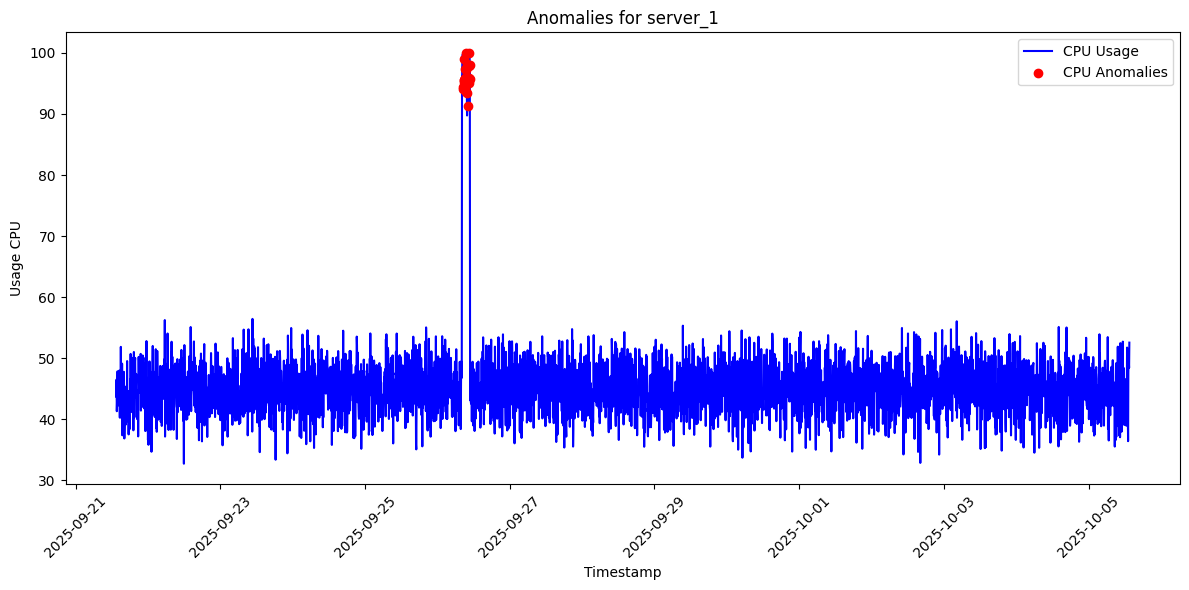

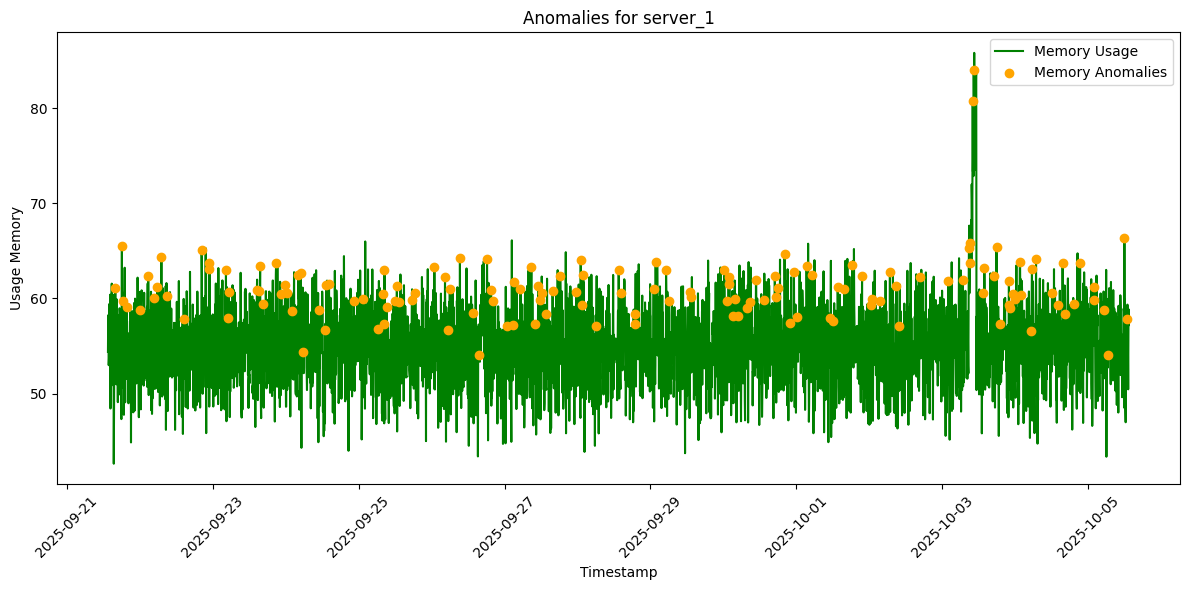

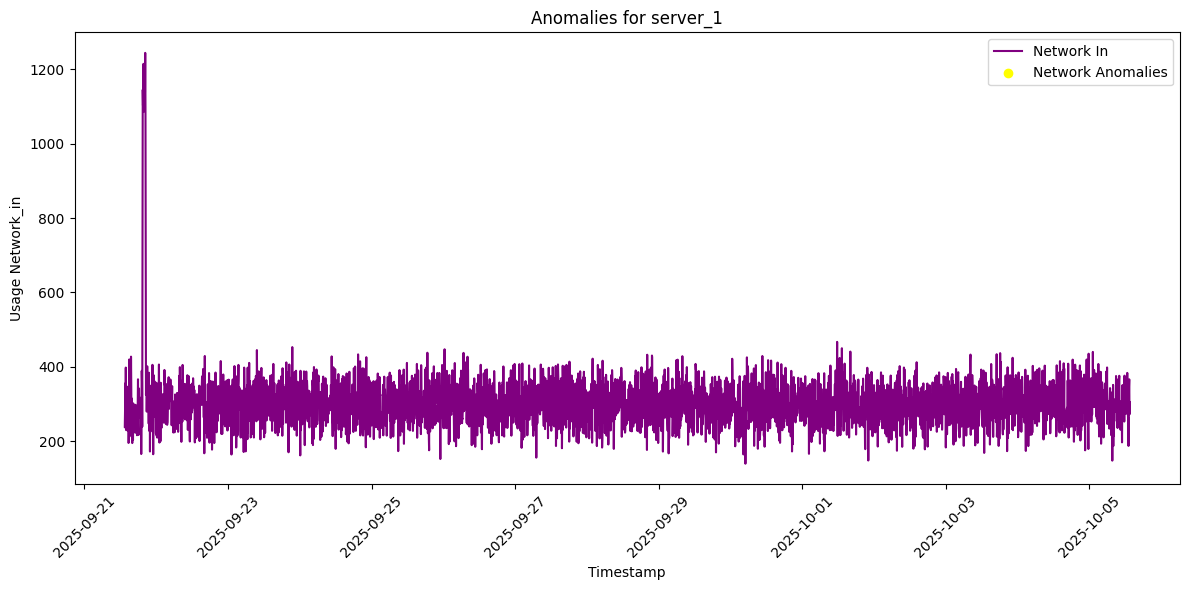

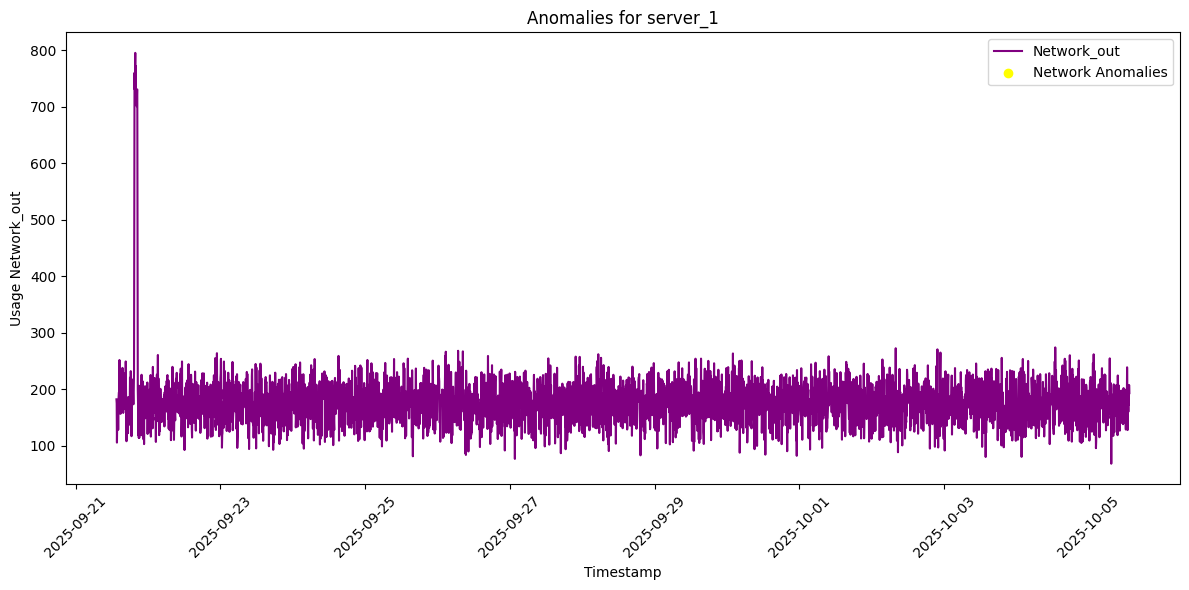

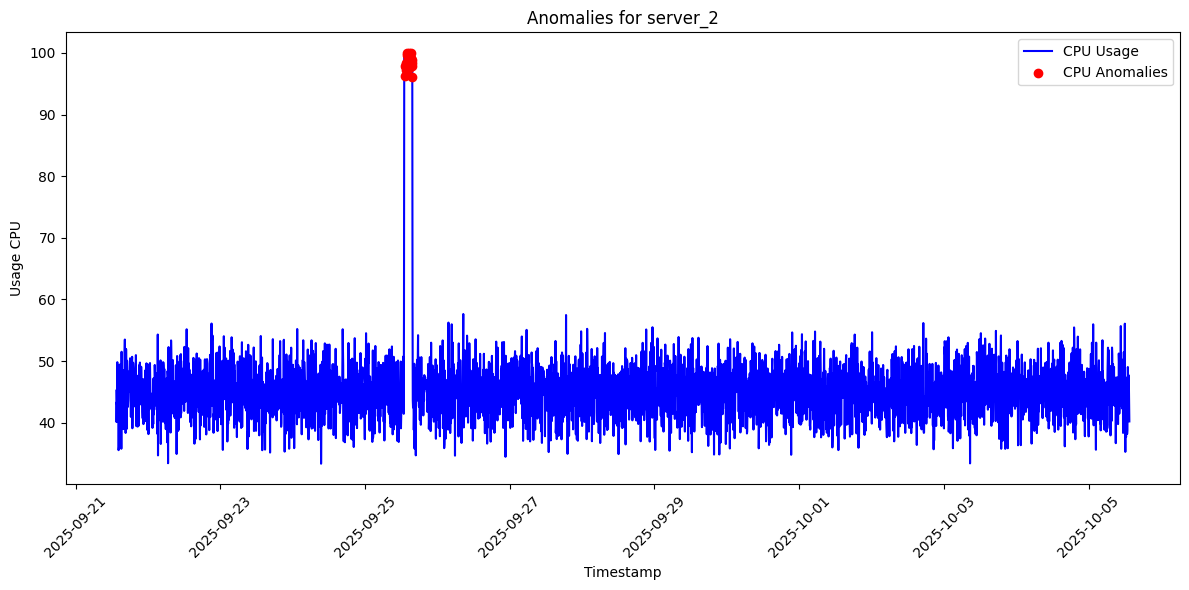

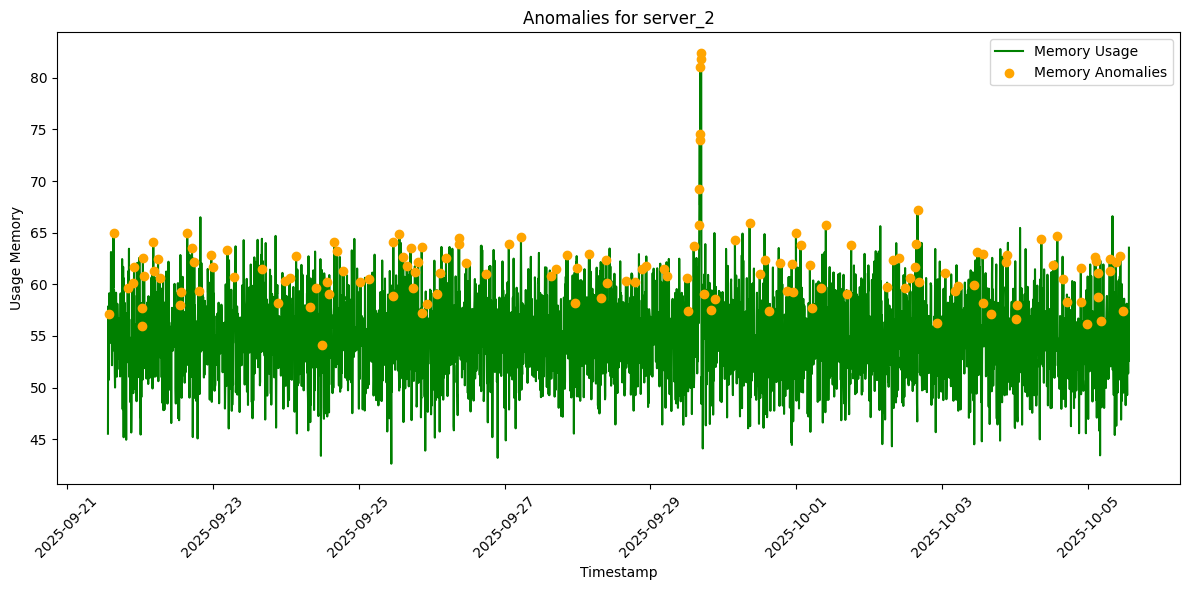

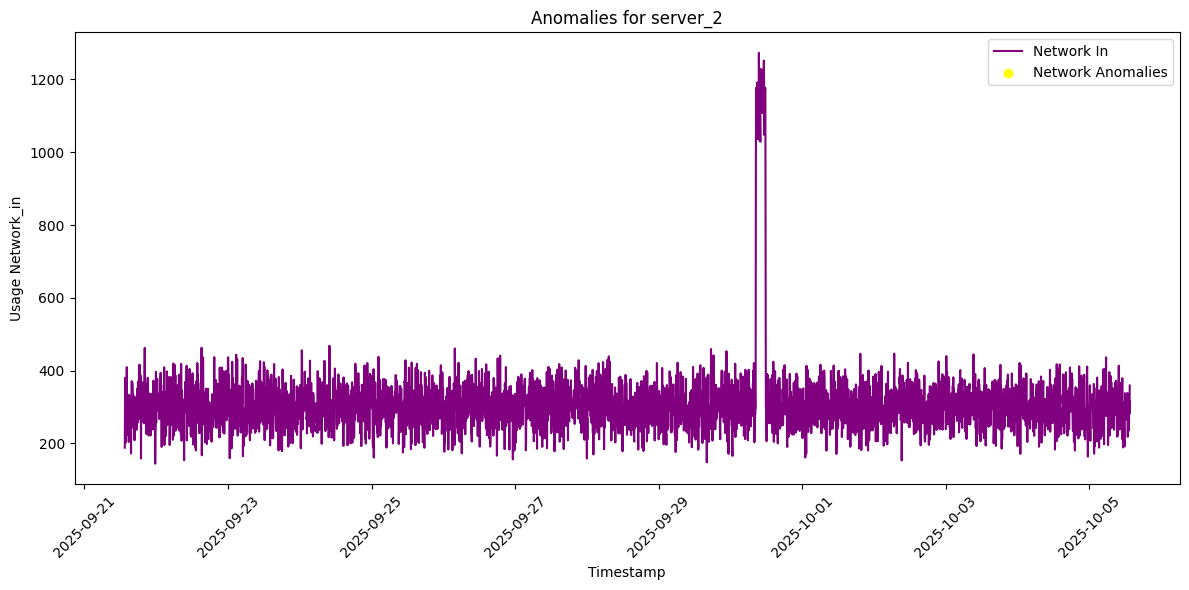

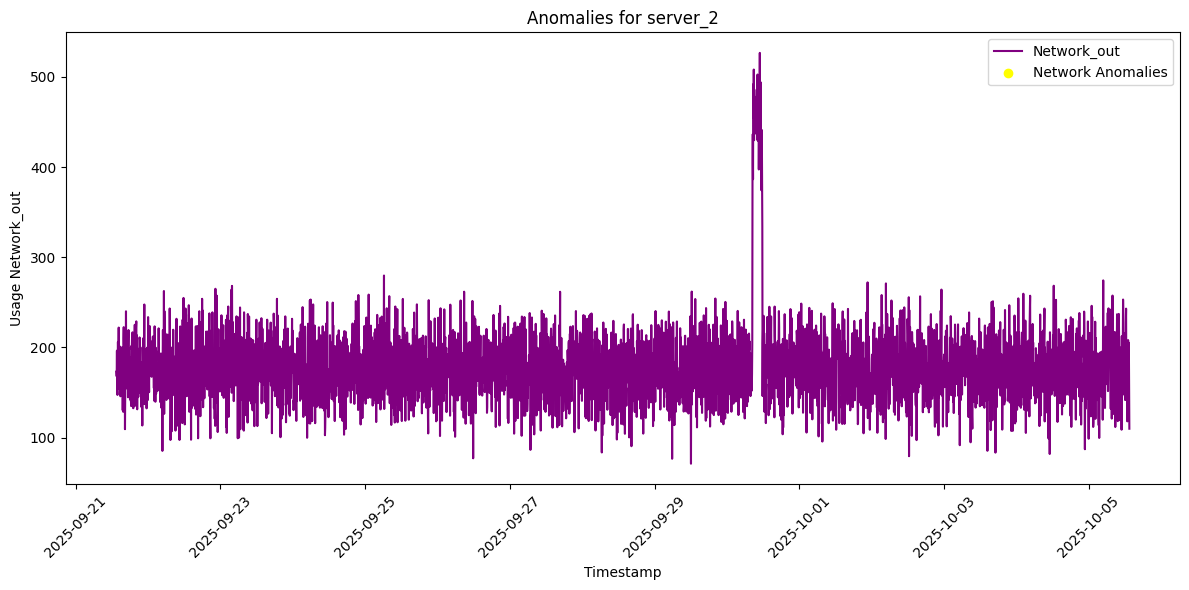

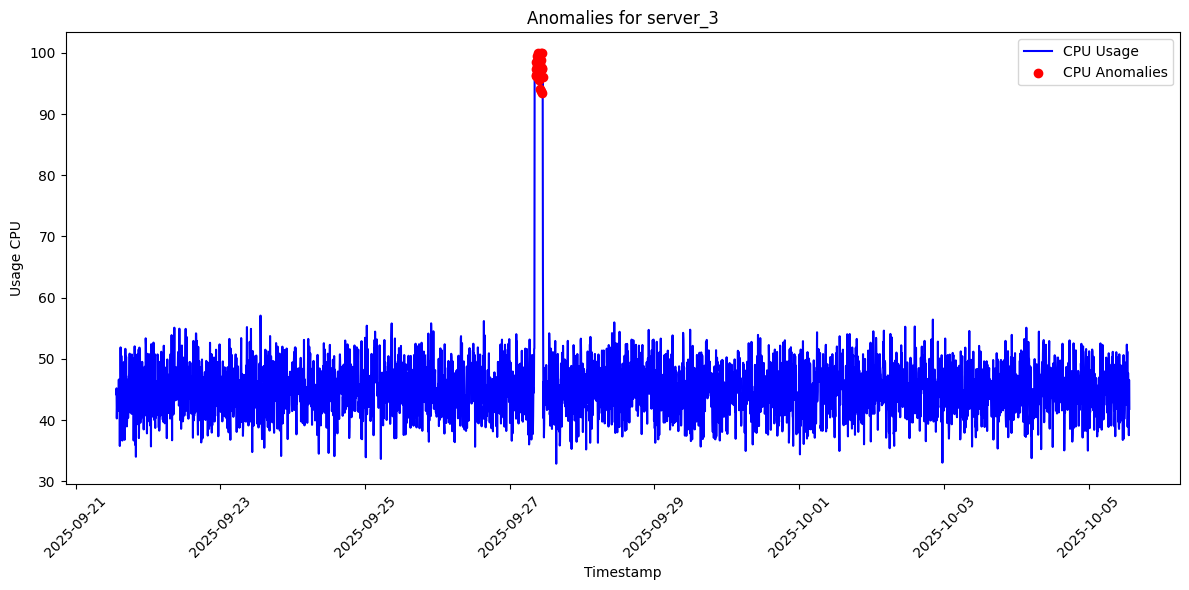

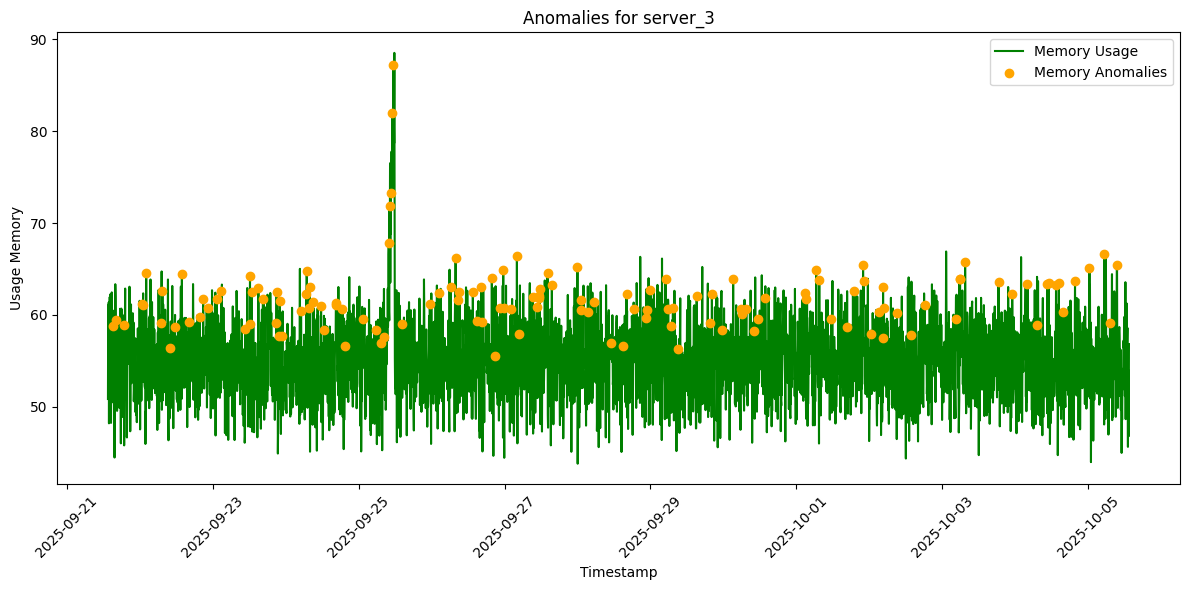

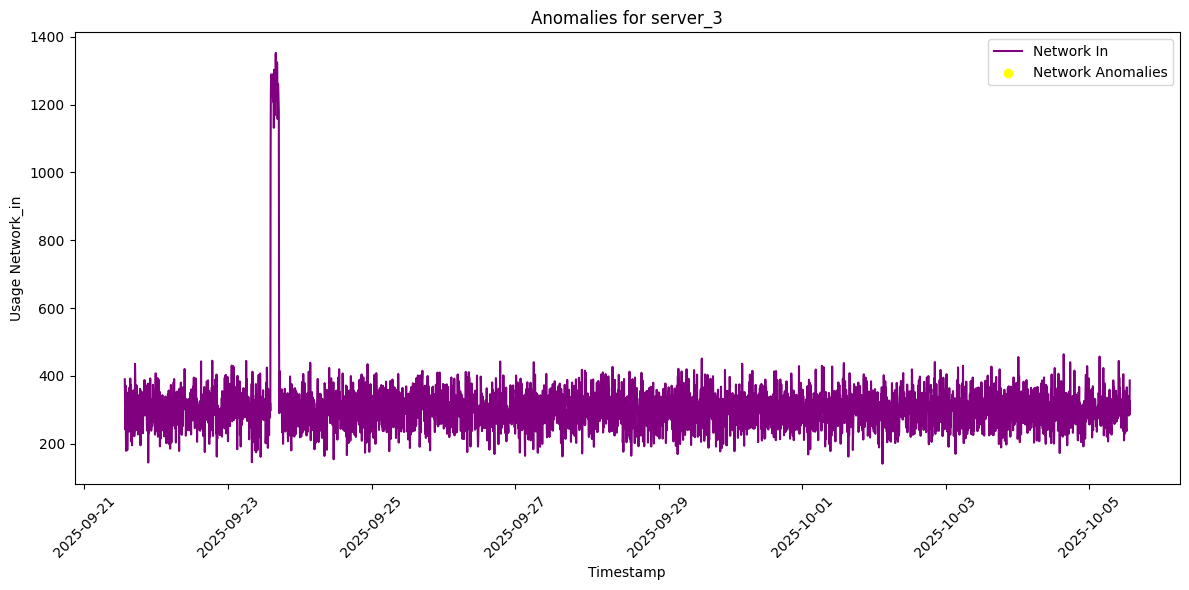

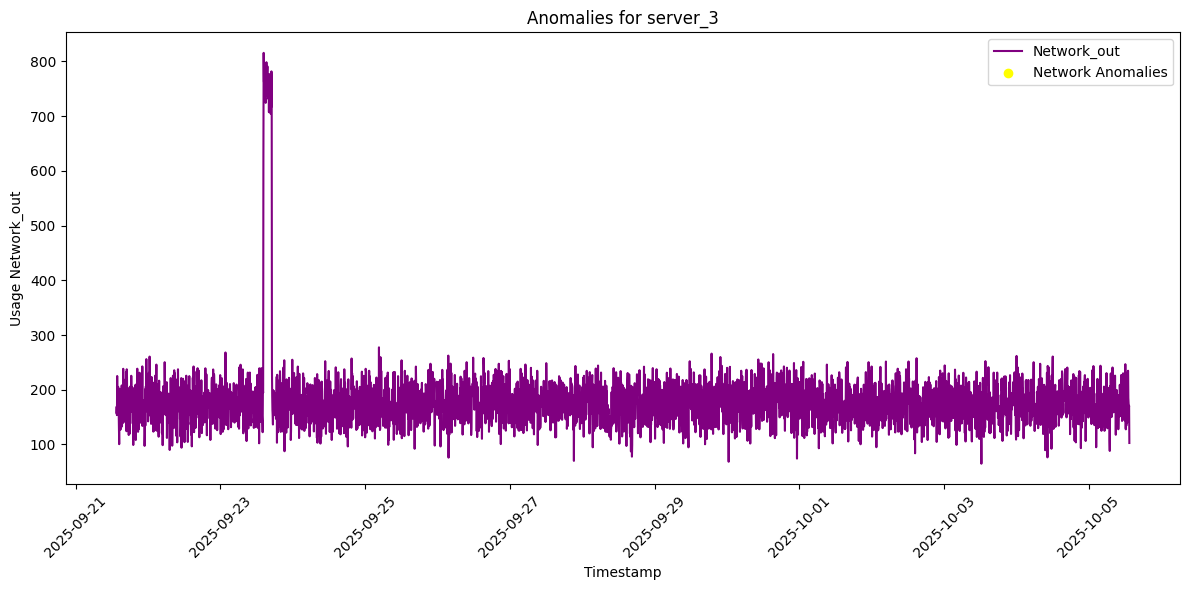

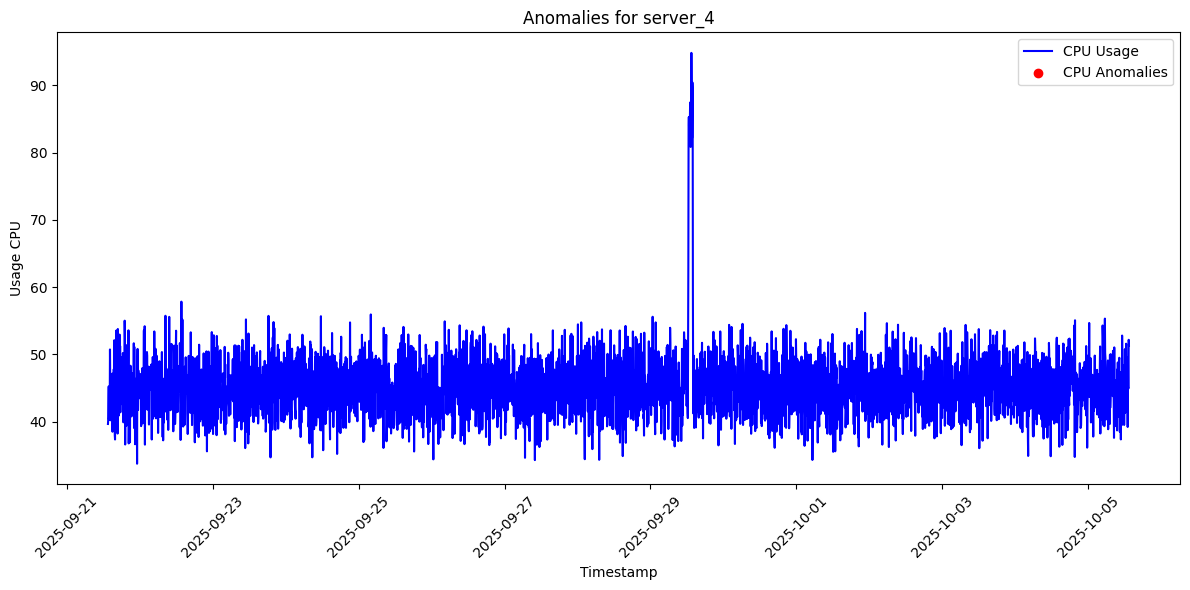

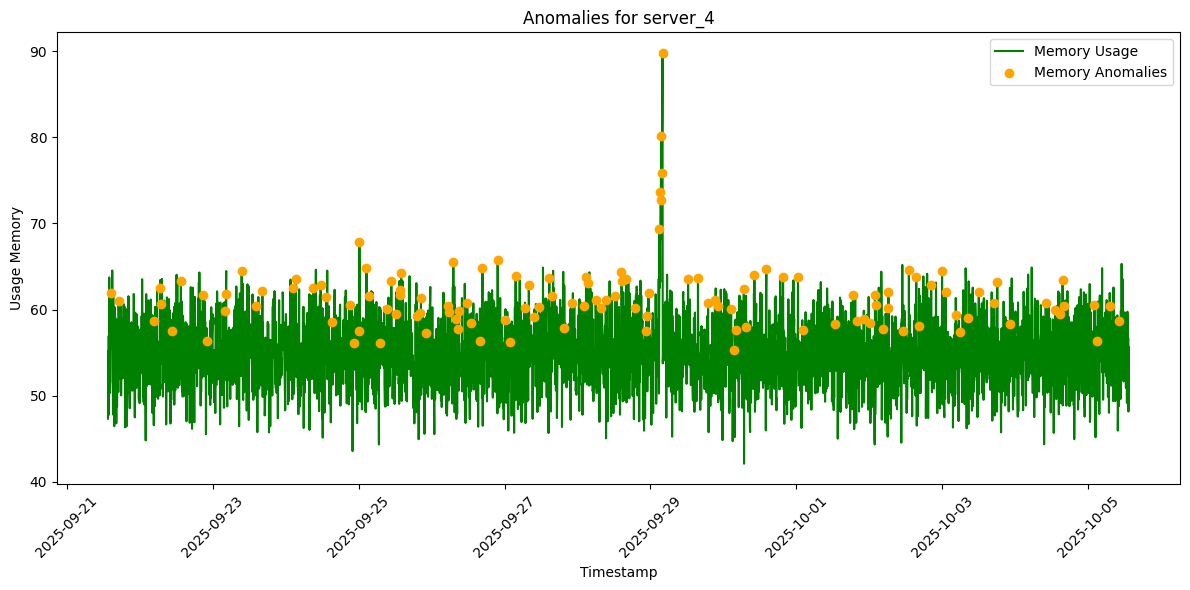

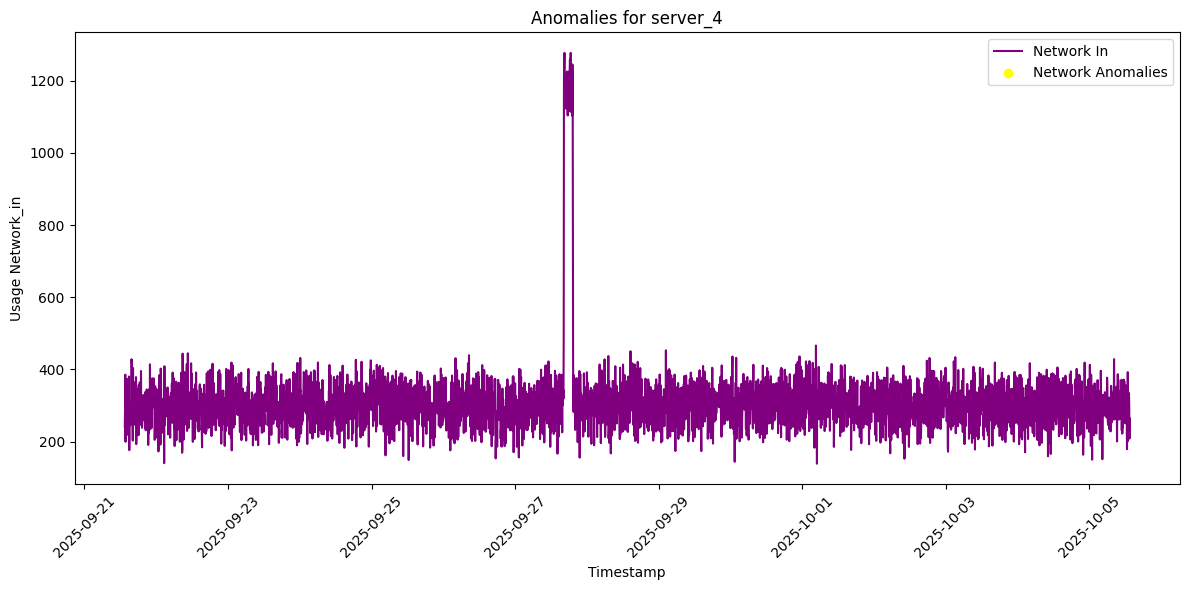

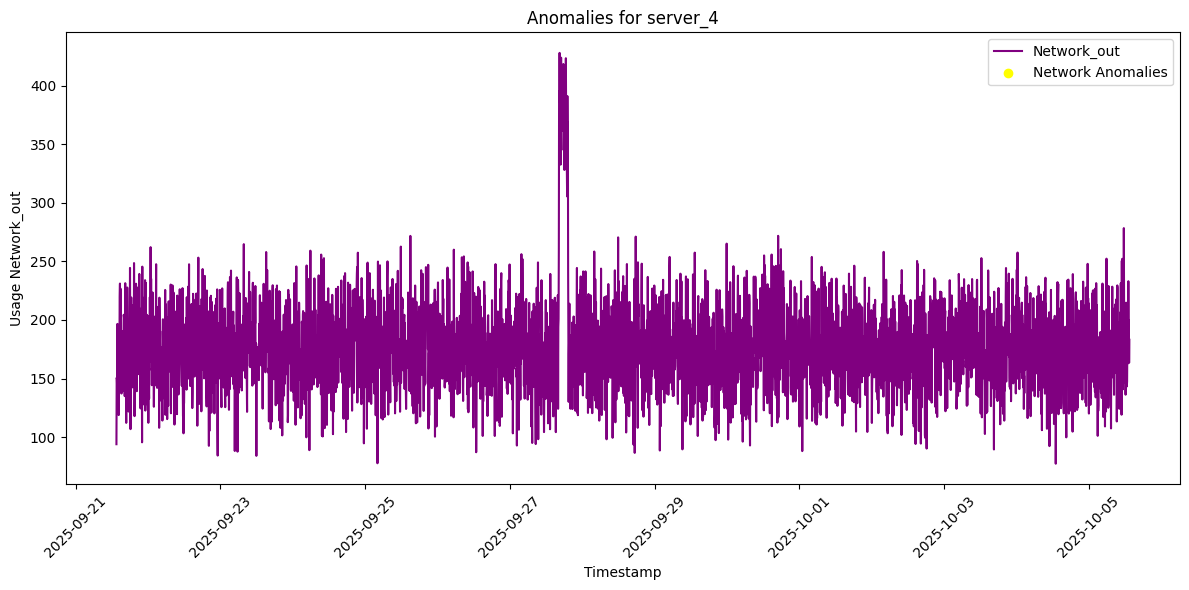

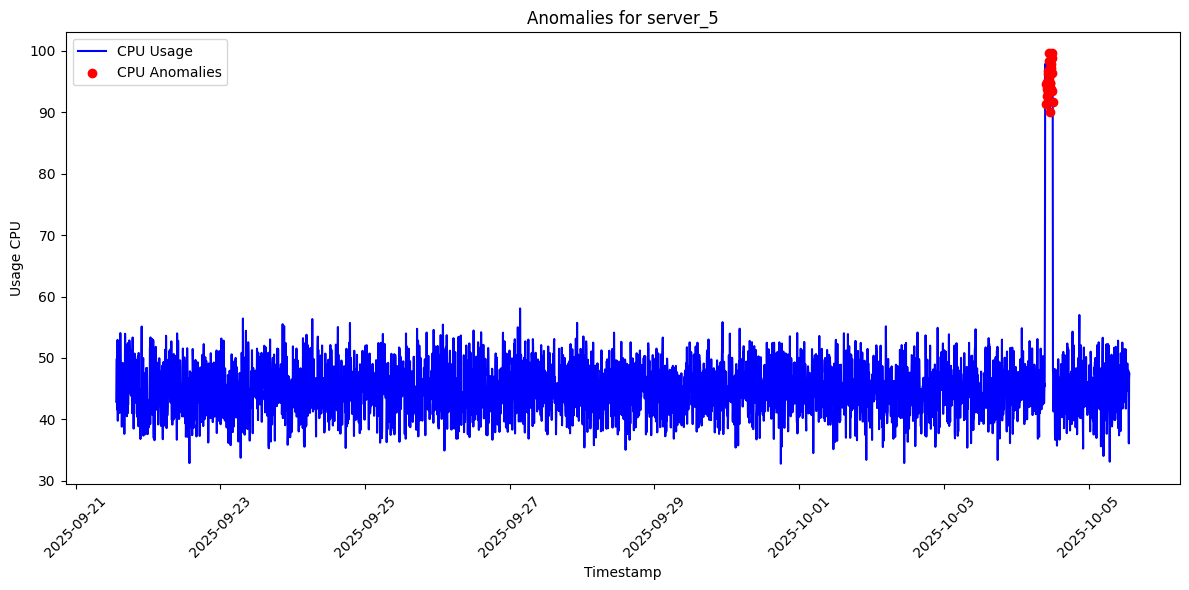

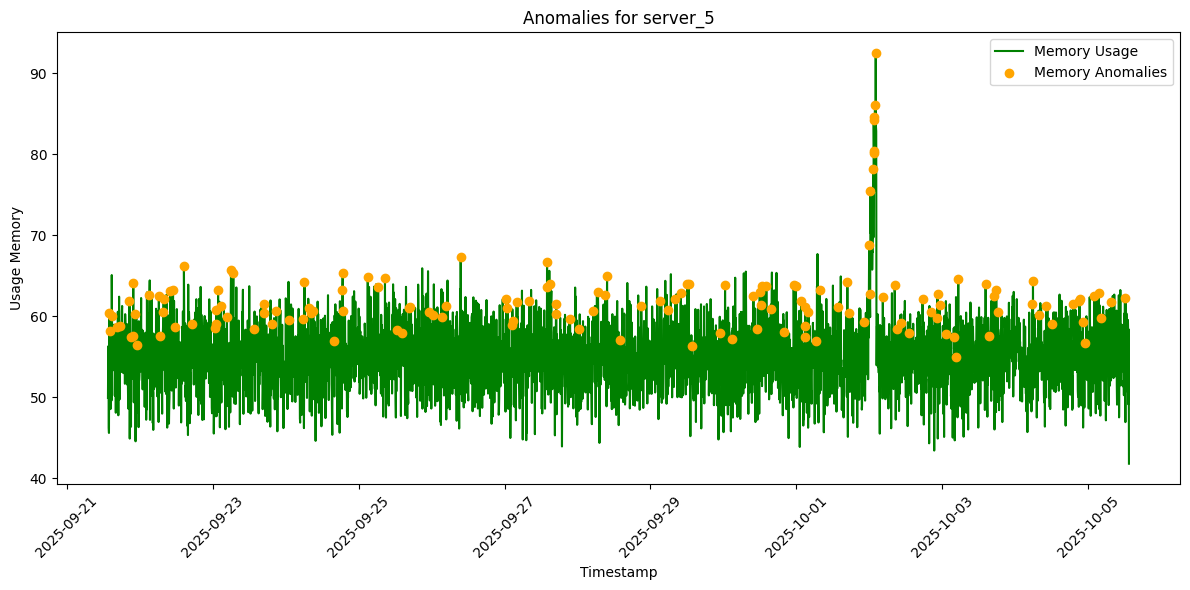

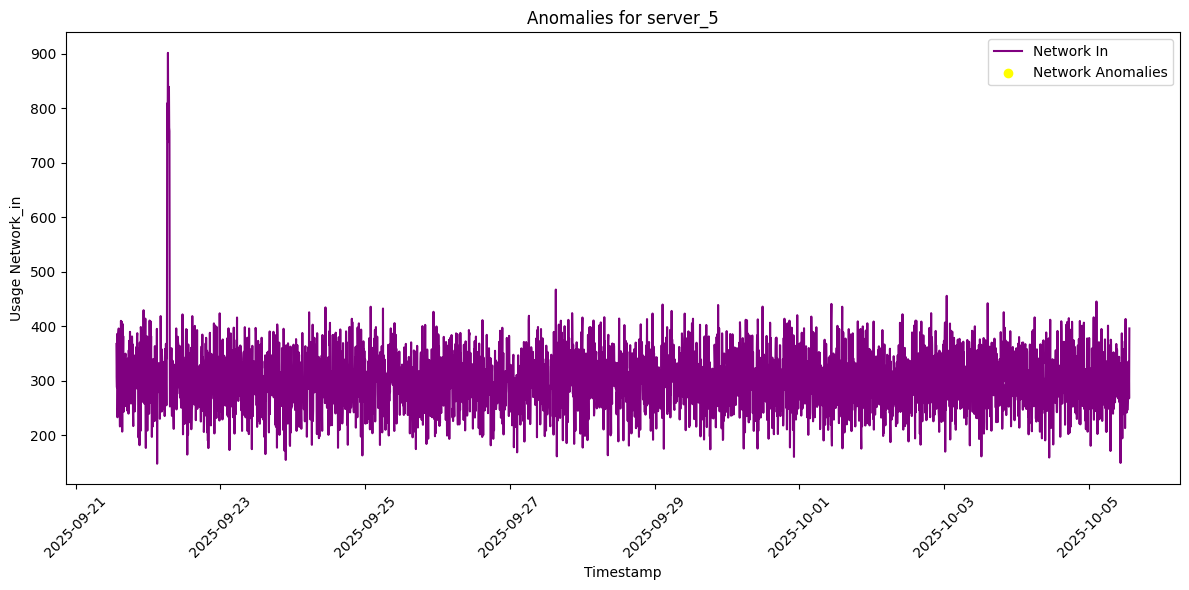

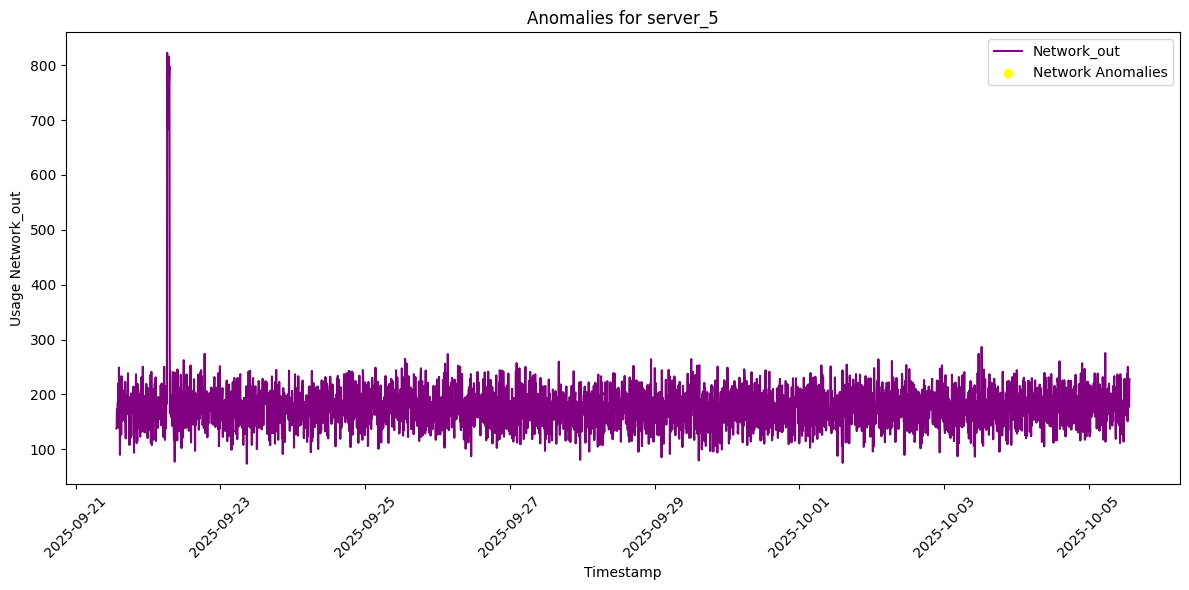

In [19]:
import matplotlib.pyplot as plt

# Loop through each server and create a plot
for server in resampled_df['server_id'].unique():
    # Filter data for the current server
    server_data = resampled_df[resampled_df['server_id'] == server]

    # Filter anomalies based on CPU, Memory, and Network
    cpu_anomaly_data = server_data[server_data['cpu_anomaly'] == True]
    memory_anomaly_data = server_data[server_data['memory_anomaly'] == True]
    network_in_anomaly_data = server_data[server_data['network_in_anomaly'] == True]
    network_out_anomaly_data = server_data[server_data['network_out_anomaly'] == True]
    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['cpu_usage'], label='CPU Usage', color='blue')
    plt.scatter(cpu_anomaly_data['timestamp'], cpu_anomaly_data['cpu_usage'], color='red', label='CPU Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage CPU')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    plt.figure(figsize=(12, 6))
     # Plot Memory usage with Memory anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['memory_usage'], label='Memory Usage', color='green')
    plt.scatter(memory_anomaly_data['timestamp'], memory_anomaly_data['memory_usage'], color='orange', label='Memory Anomalies', zorder=5)
    plt.title(f'Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage Memory')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 6))
    # Plot Network usage with Network anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['network_in'], label='Network In', color='purple')
    plt.scatter(network_in_anomaly_data['timestamp'], network_in_anomaly_data['network_in'], color='yellow', label='Network Anomalies', zorder=5)
    plt.title(f'Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage Network_in')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 6))
    # Plot Network usage with Network anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['network_out'], label='Network_out', color='purple')
    plt.scatter(network_out_anomaly_data['timestamp'], network_out_anomaly_data['network_out'], color='yellow', label='Network Anomalies', zorder=5)
    plt.title(f'Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage Network_out')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

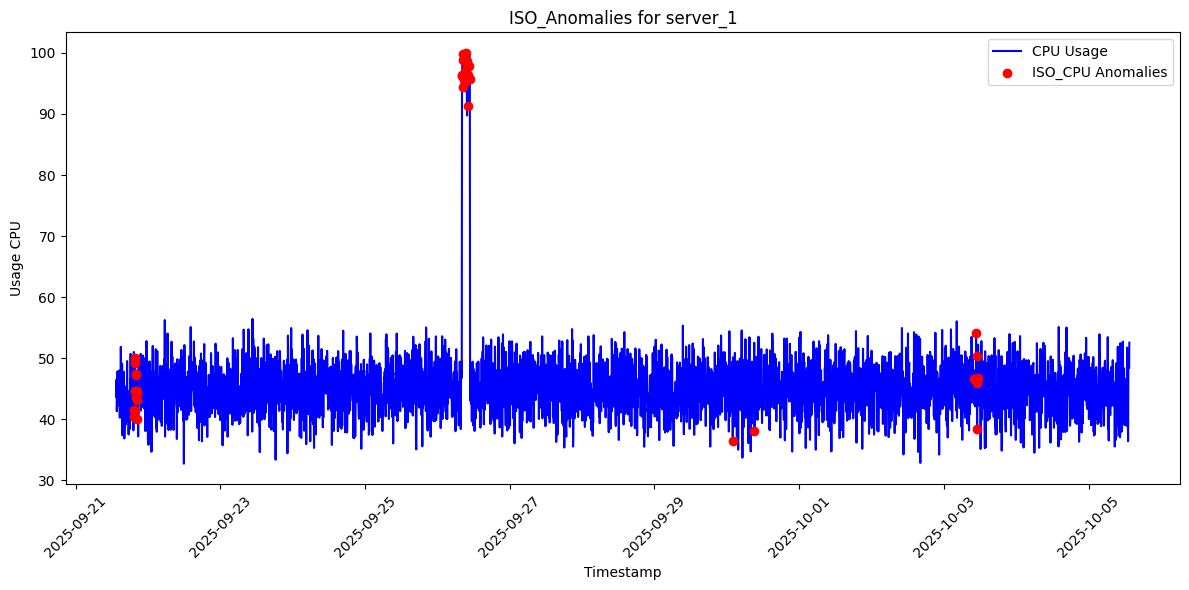

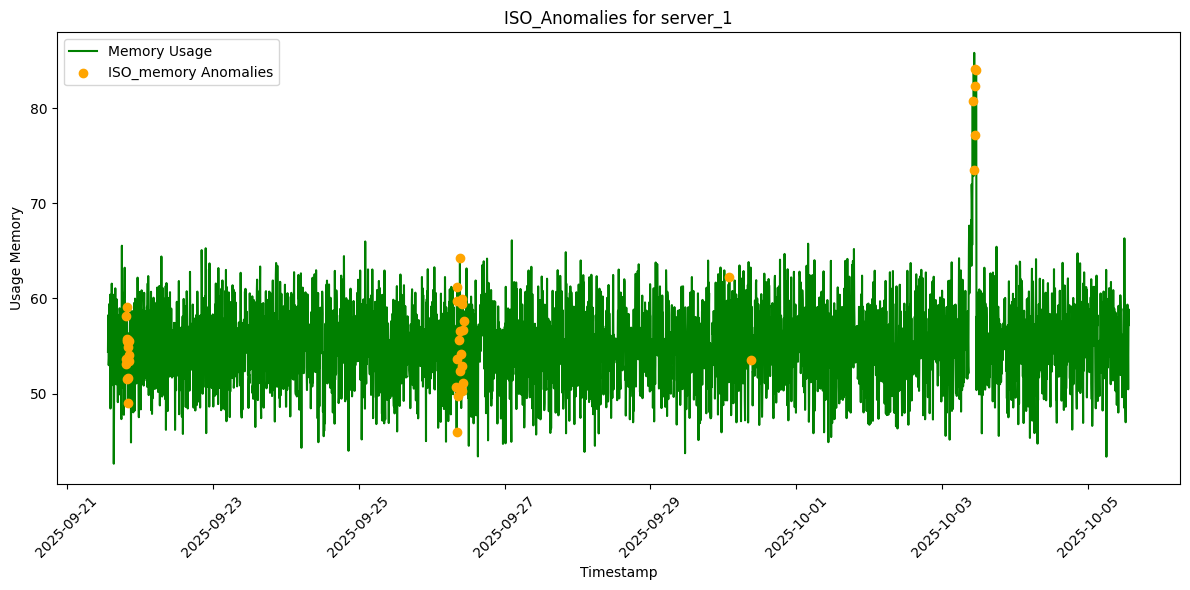

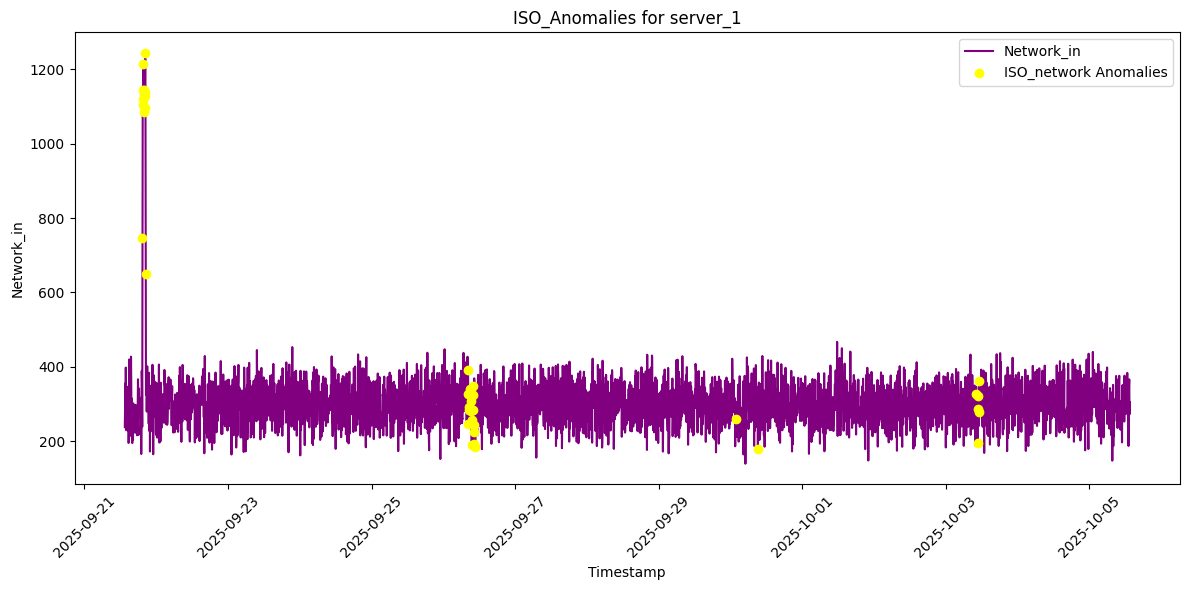

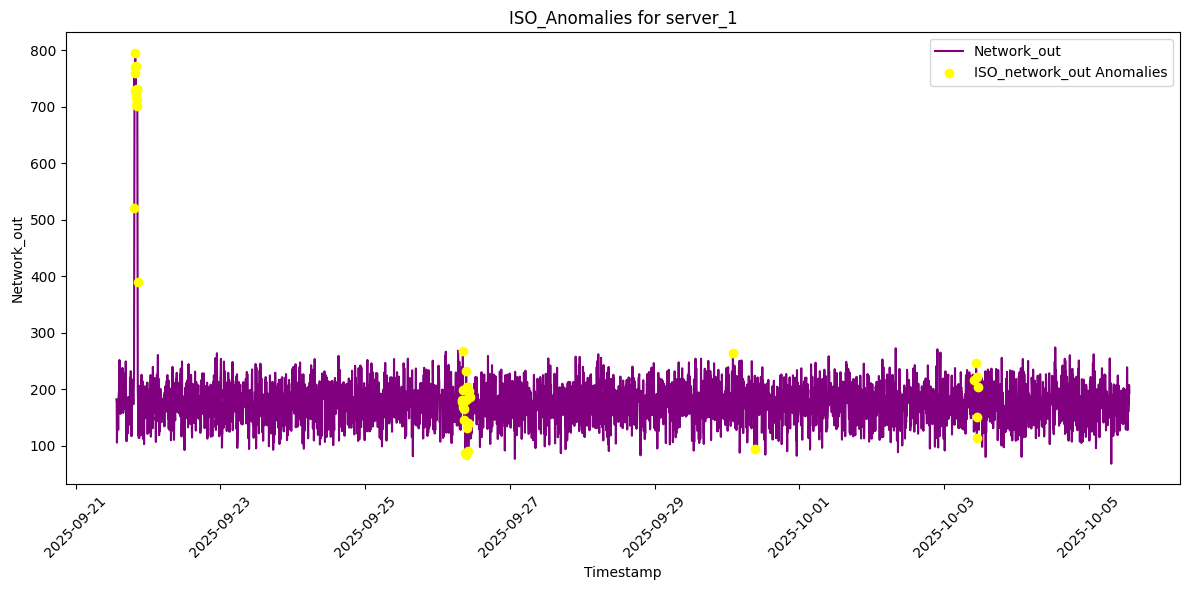

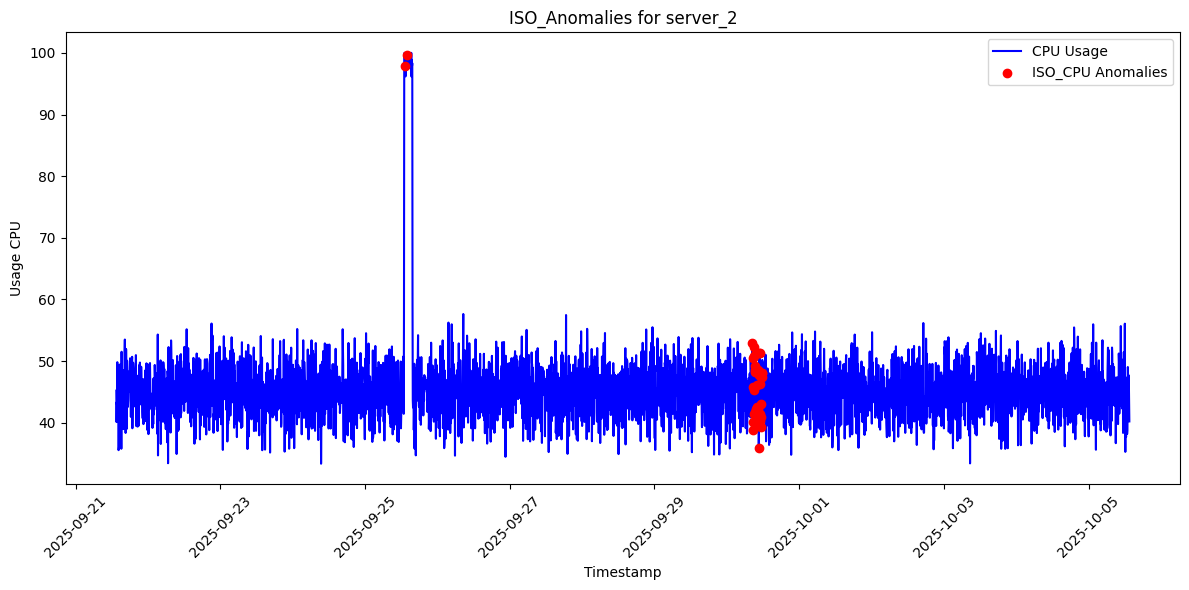

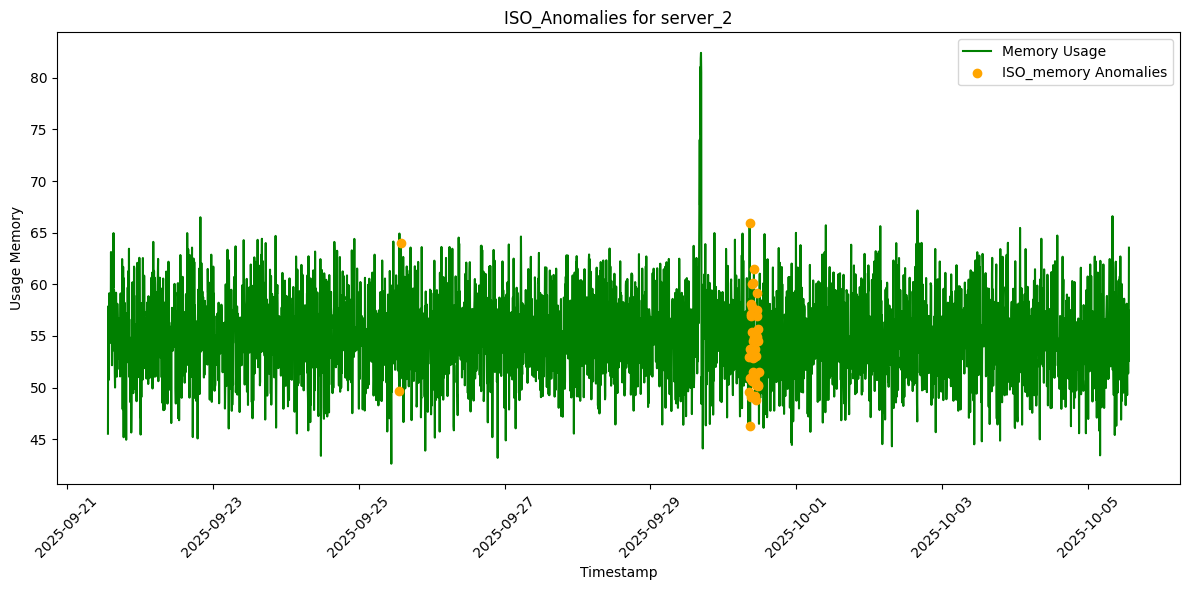

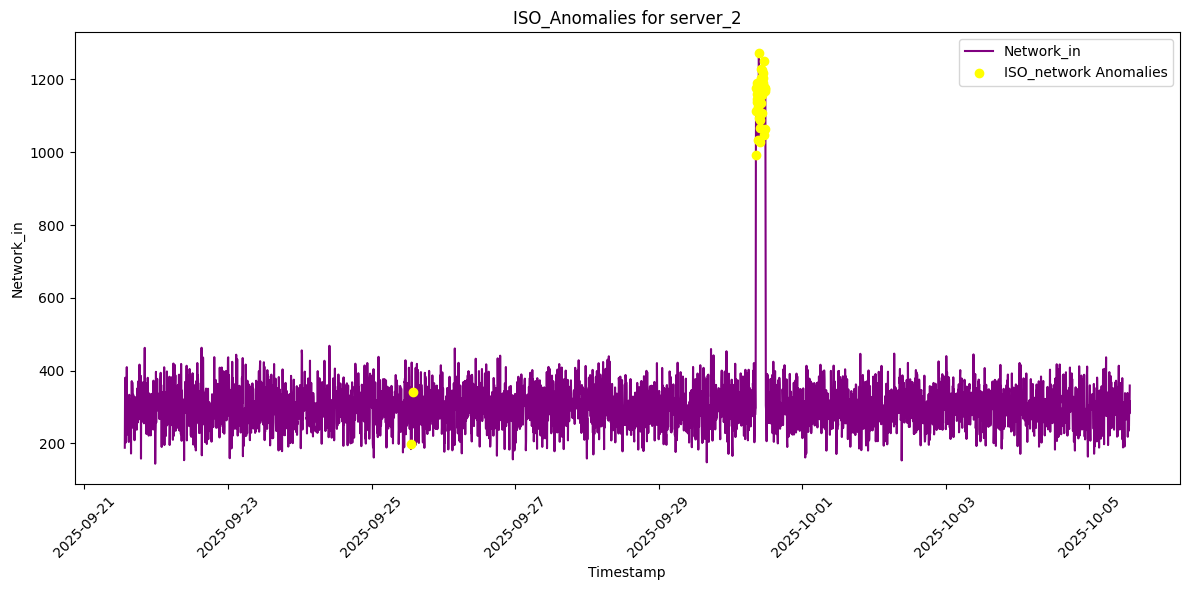

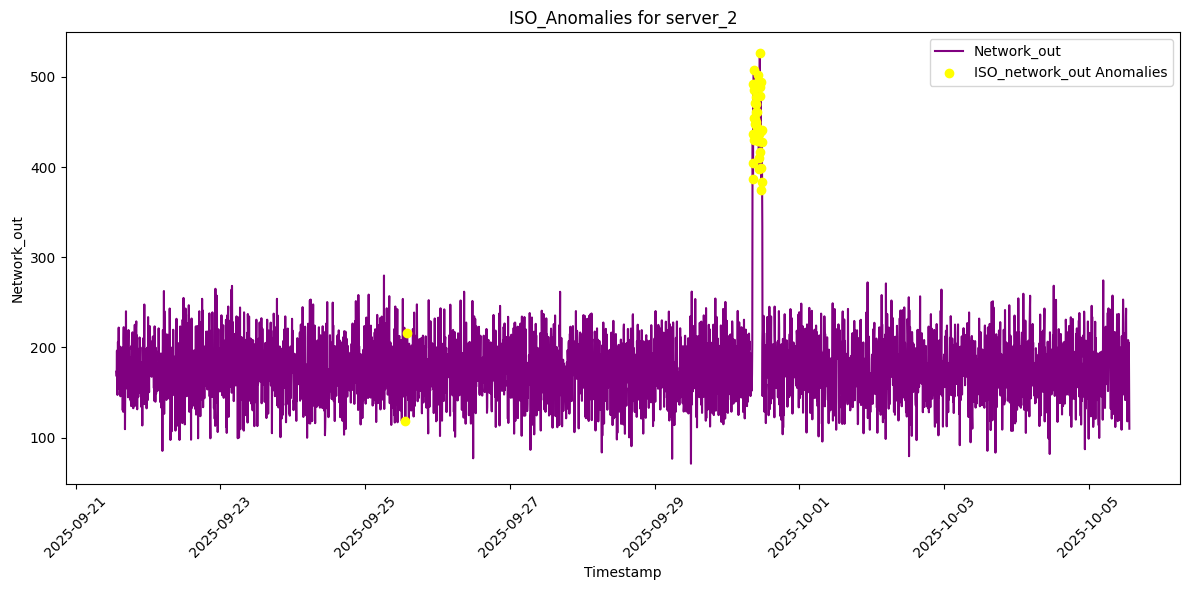

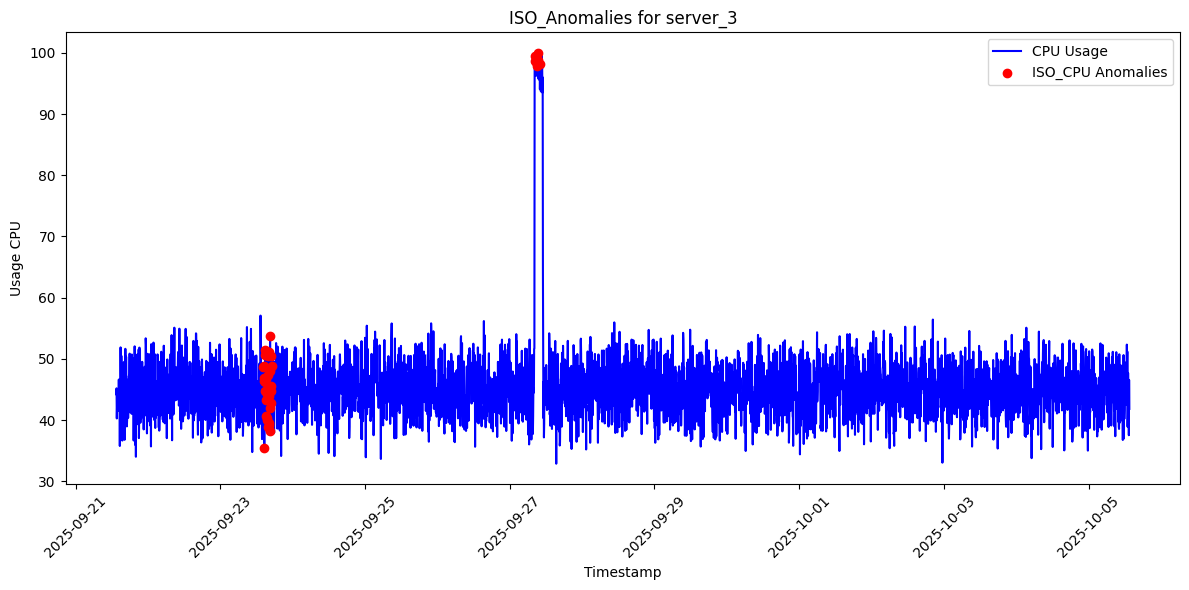

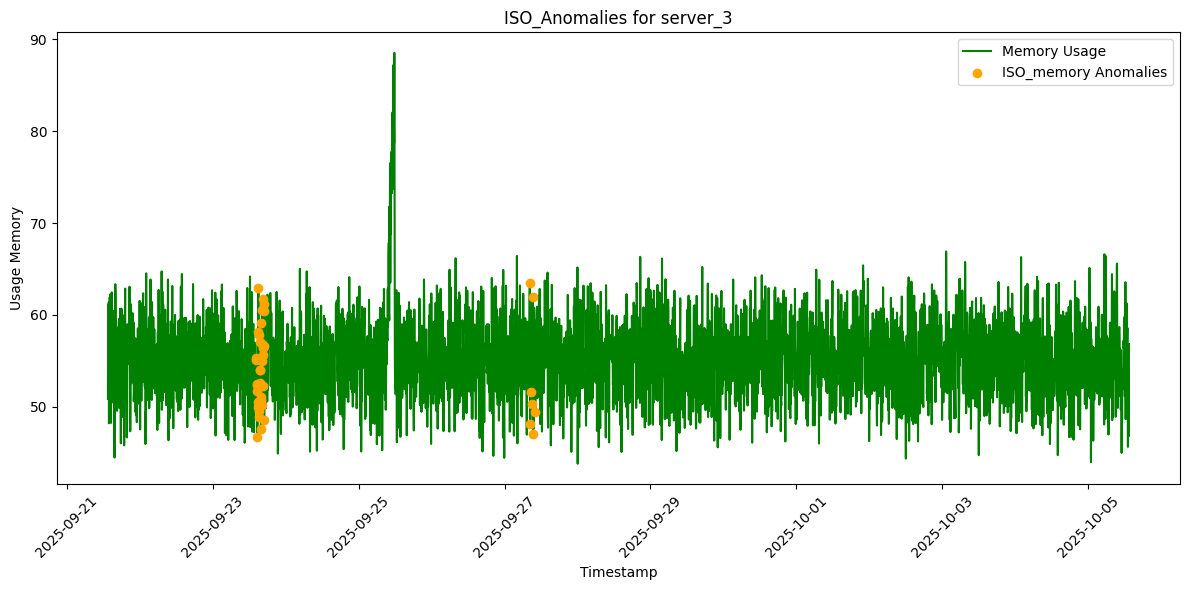

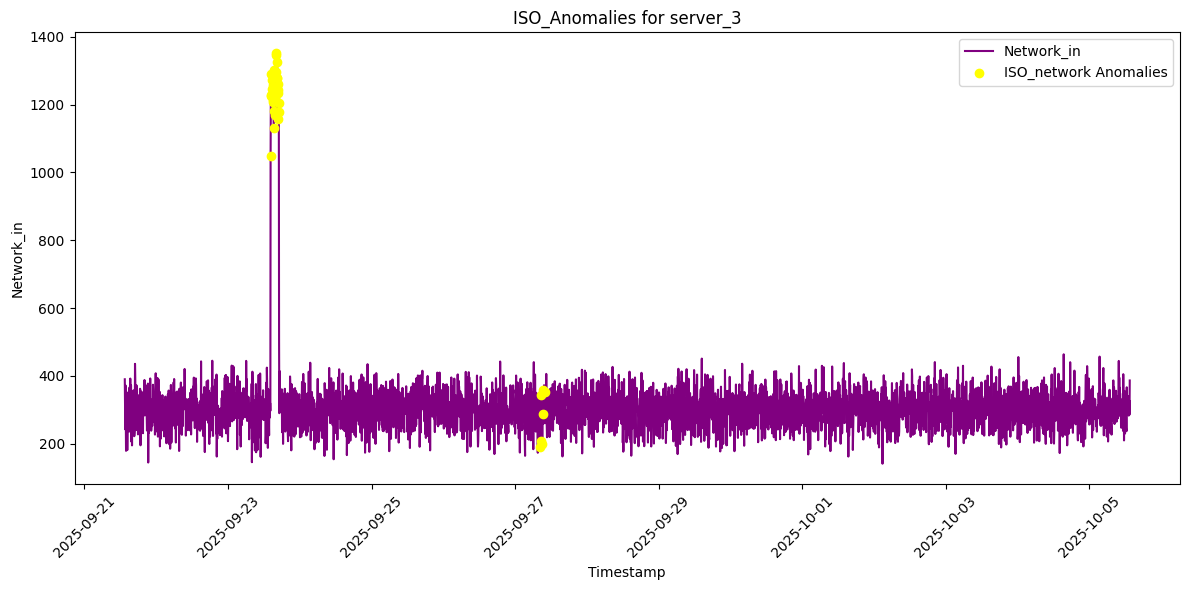

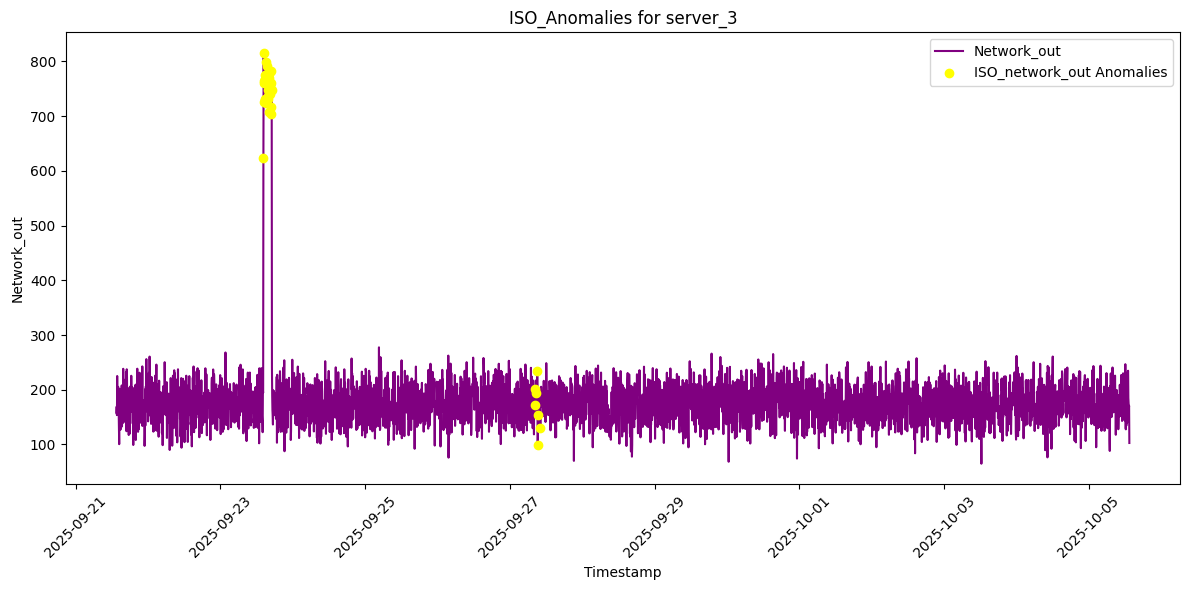

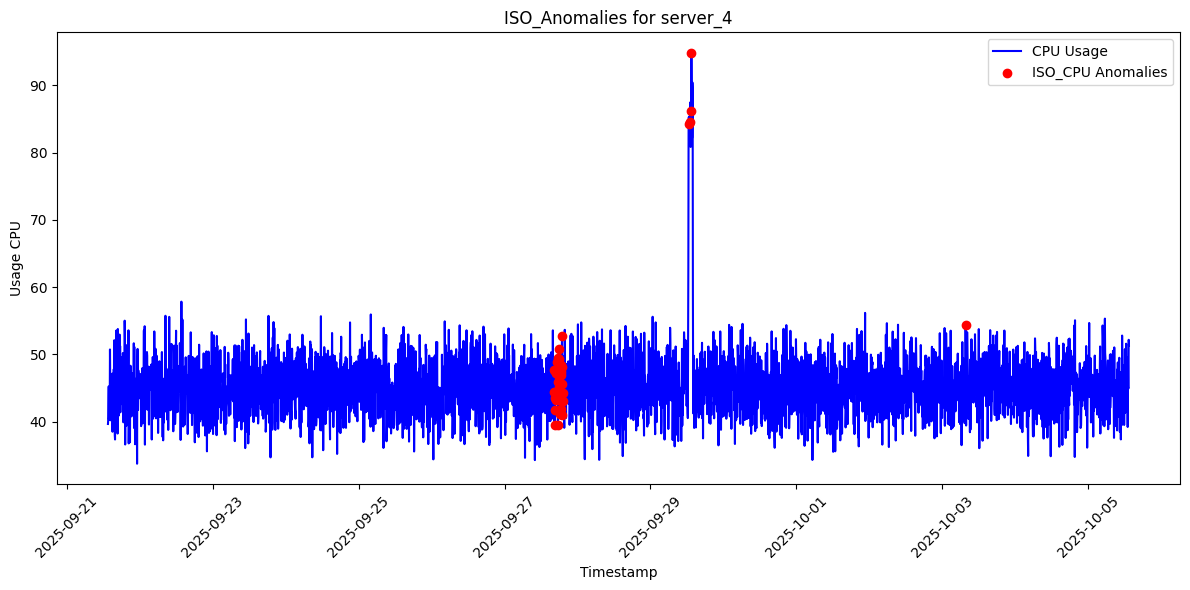

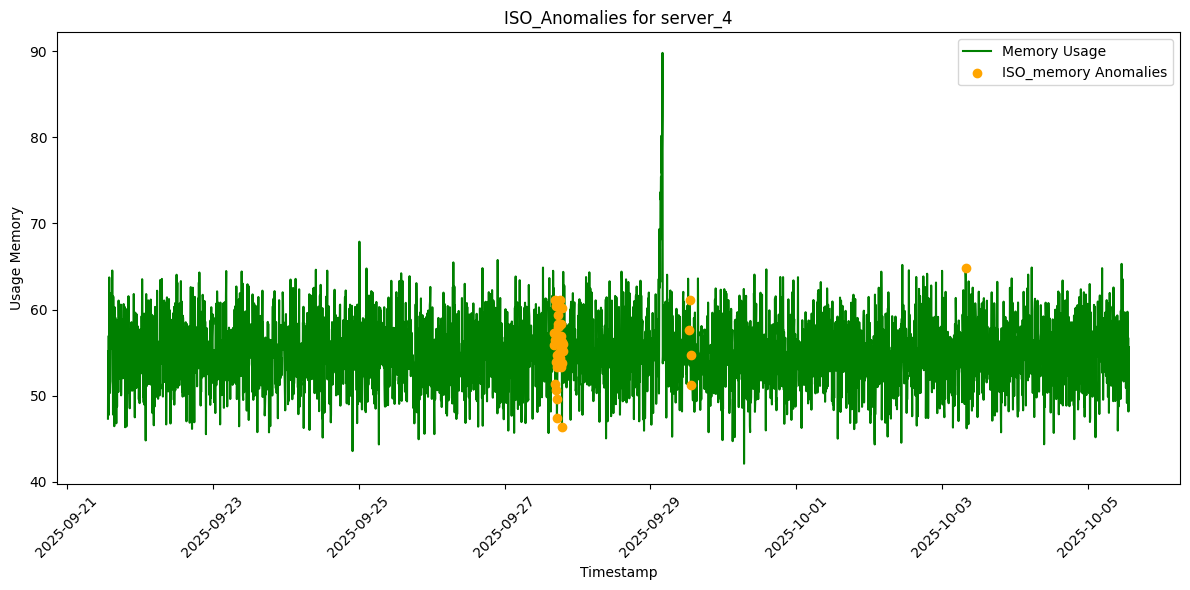

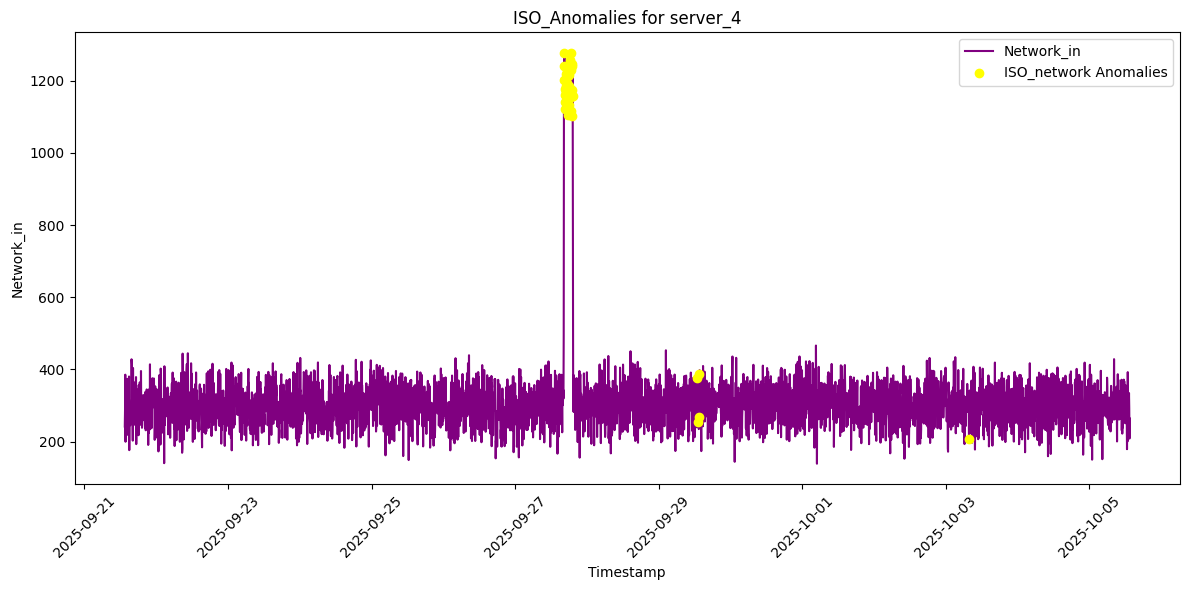

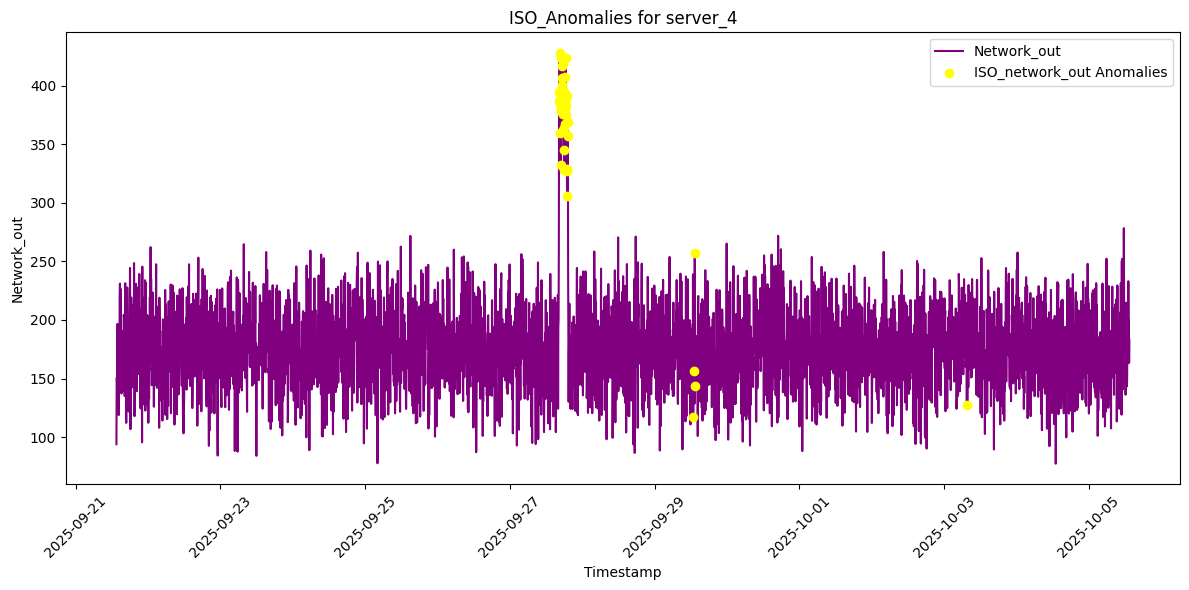

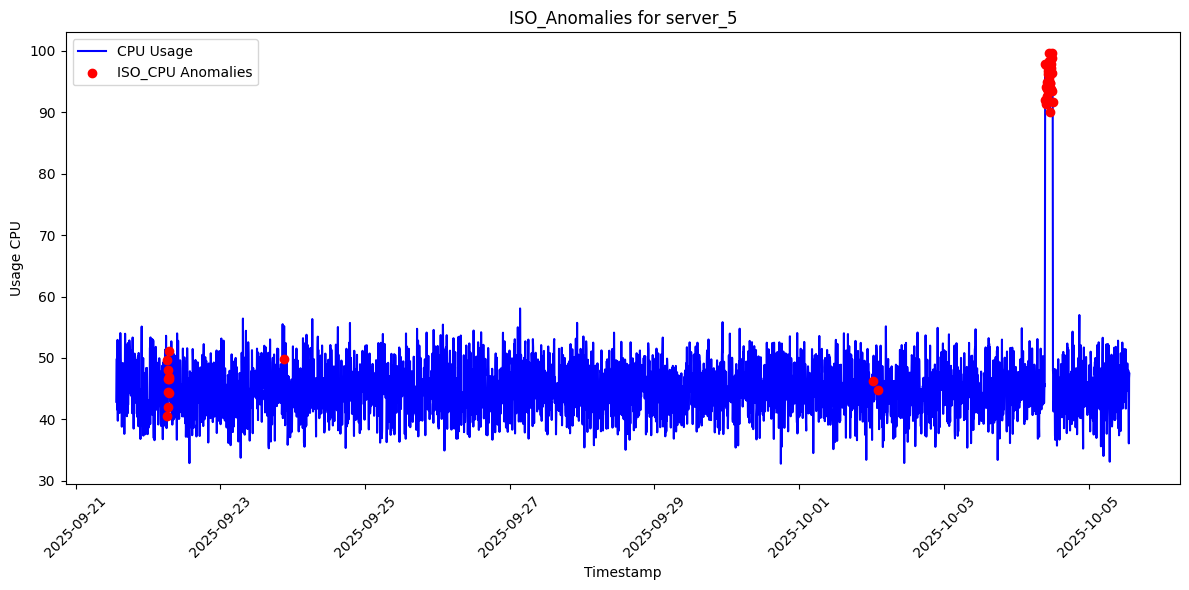

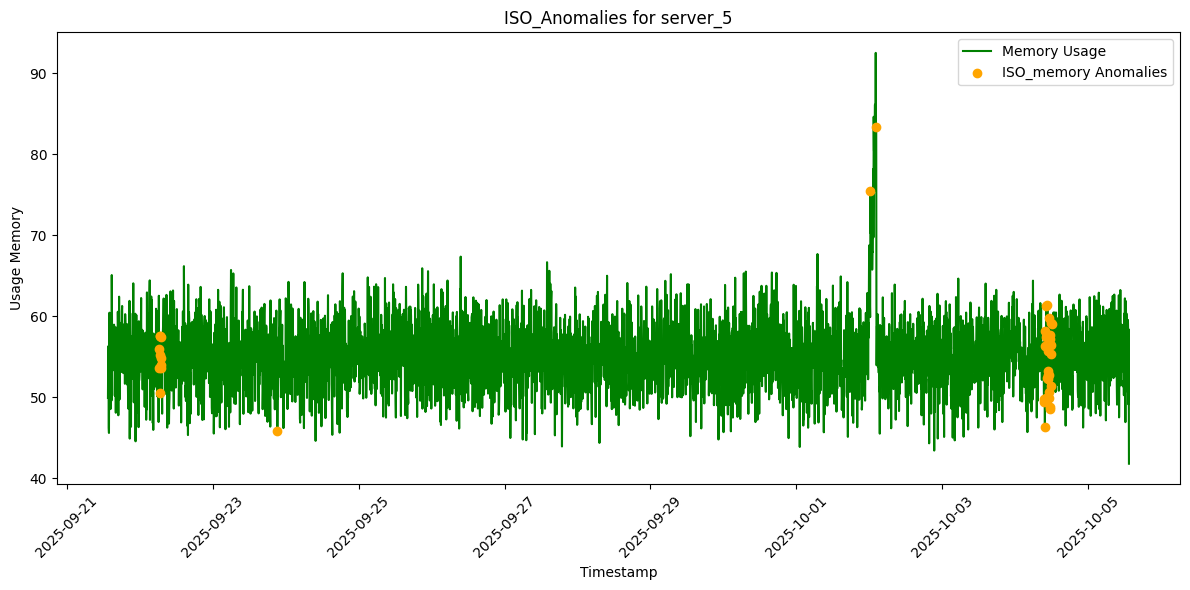

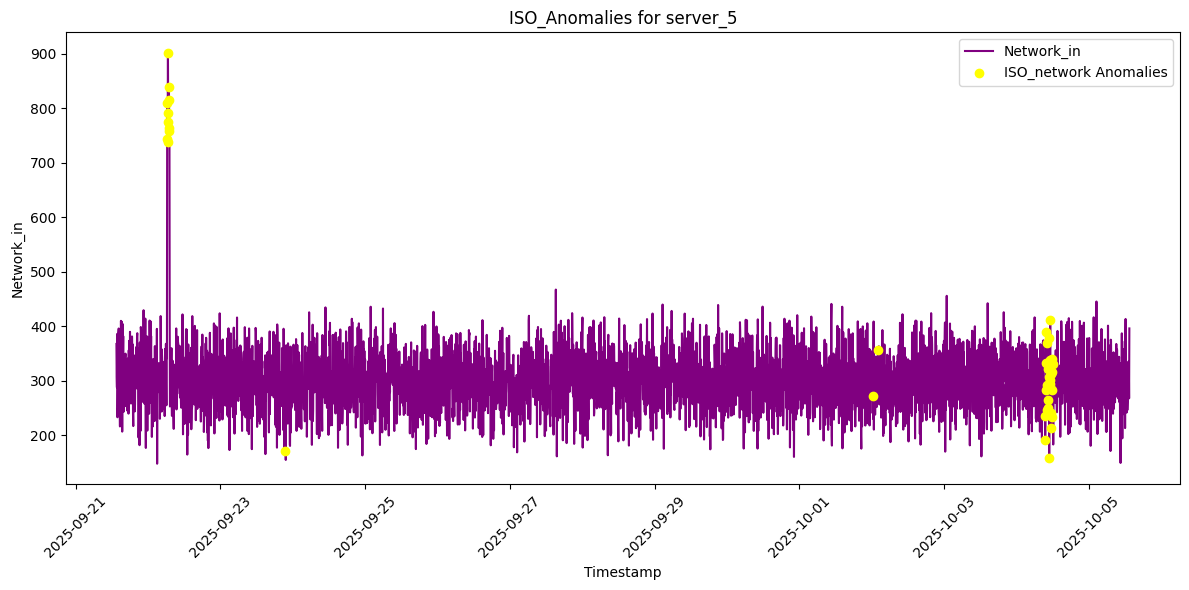

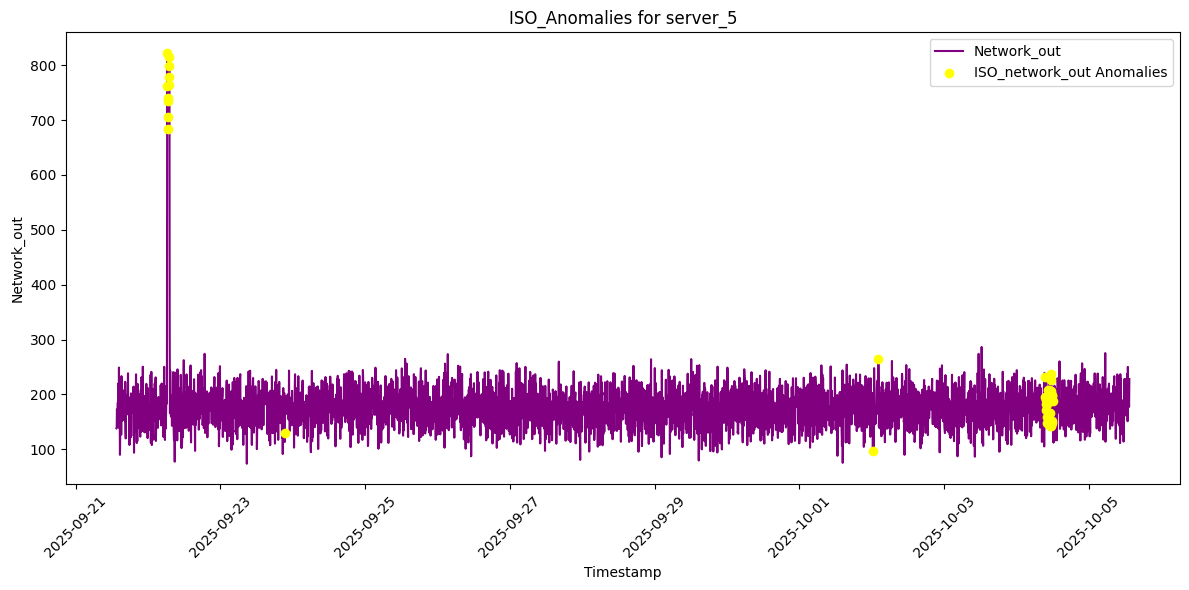

In [28]:
for server in resampled_df['server_id'].unique():
    # Filter data for the current server
    server_data = resampled_df[resampled_df['server_id'] == server]

    # Filter anomalies based on CPU, Memory, and Network
    Iso_anomaly_data = server_data[server_data['anomaly'] == -1]
   
    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['cpu_usage'], label='CPU Usage', color='blue')
    plt.scatter(Iso_anomaly_data['timestamp'], Iso_anomaly_data['cpu_usage'], color='red', label='ISO_CPU Anomalies', zorder=5)
   
    # Set title and labels
    plt.title(f'ISO_Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage CPU')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['memory_usage'], label='Memory Usage', color='green')
    plt.scatter(Iso_anomaly_data['timestamp'], Iso_anomaly_data['memory_usage'], color='orange', label='ISO_memory Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'ISO_Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage Memory')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['network_in'], label='Network_in', color='purple')
    plt.scatter(Iso_anomaly_data['timestamp'], Iso_anomaly_data['network_in'], color='yellow', label='ISO_network Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'ISO_Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Network_in')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['network_out'], label='Network_out', color='purple')
    plt.scatter(Iso_anomaly_data['timestamp'], Iso_anomaly_data['network_out'], color='yellow', label='ISO_network_out Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'ISO_Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Network_out')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()

#### One Class- SVM

In [20]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [21]:
def apply_one_class_svm(group):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(group[numeric_cols])
    
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu = proportion of anomalies
    preds = svm.fit_predict(X_scaled)
    
    group['svm_anomaly'] = preds
    group['svm_anomaly_label'] = group['svm_anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')
    return group

In [22]:
resampled_df = resampled_df.reset_index(drop=True)
# Apply the second model
resampled_df = resampled_df.groupby('server_id', group_keys=False).apply(apply_one_class_svm)

C:\Users\vedant\AppData\Local\Temp\ipykernel_36520\979849258.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_df = resampled_df.groupby('server_id', group_keys=False).apply(apply_one_class_svm)


In [24]:
resampled_df['combined_anomaly_v2'] = (
    resampled_df['cpu_anomaly'] |
    resampled_df['memory_anomaly'] |
    resampled_df['network_in_anomaly'] |
    resampled_df['network_out_anomaly'] |
    (resampled_df['svm_anomaly'] == -1)
)

resampled_df['final_anomaly_label_v2'] = resampled_df['combined_anomaly_v2'].apply(
    lambda x: 'Anomaly' if x else 'Normal'
)

#### Data Visualization with SVM predicted anomalies

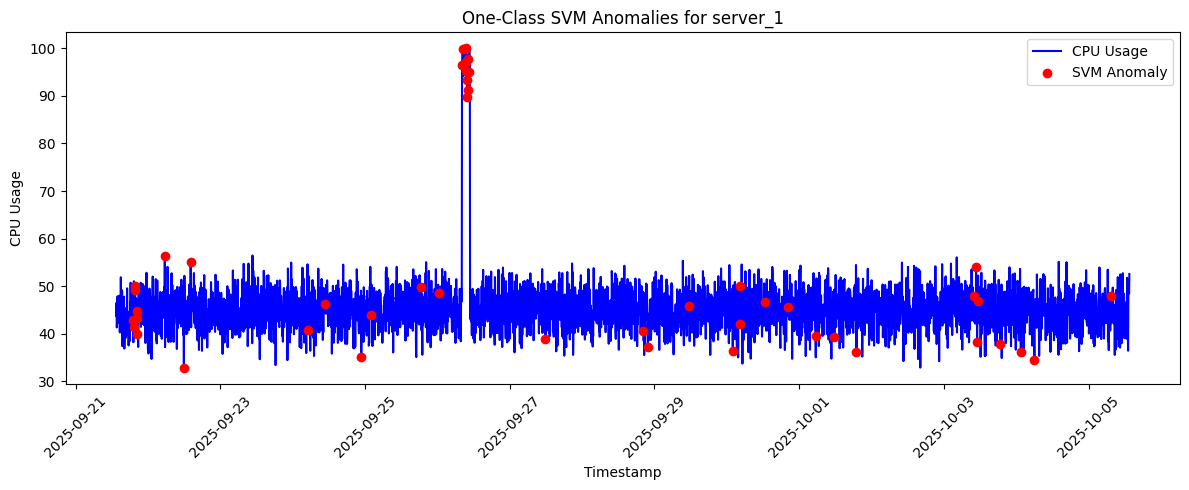

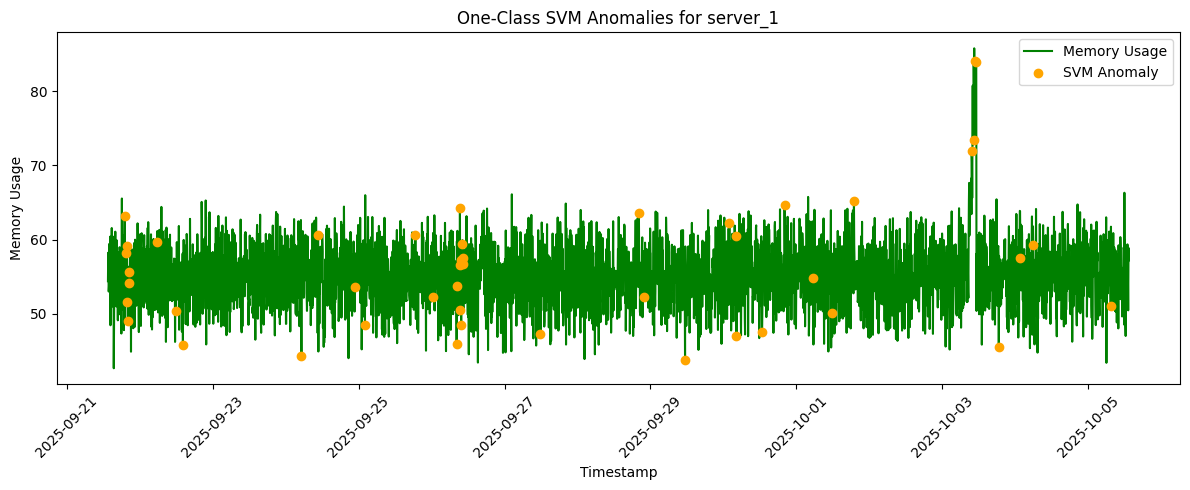

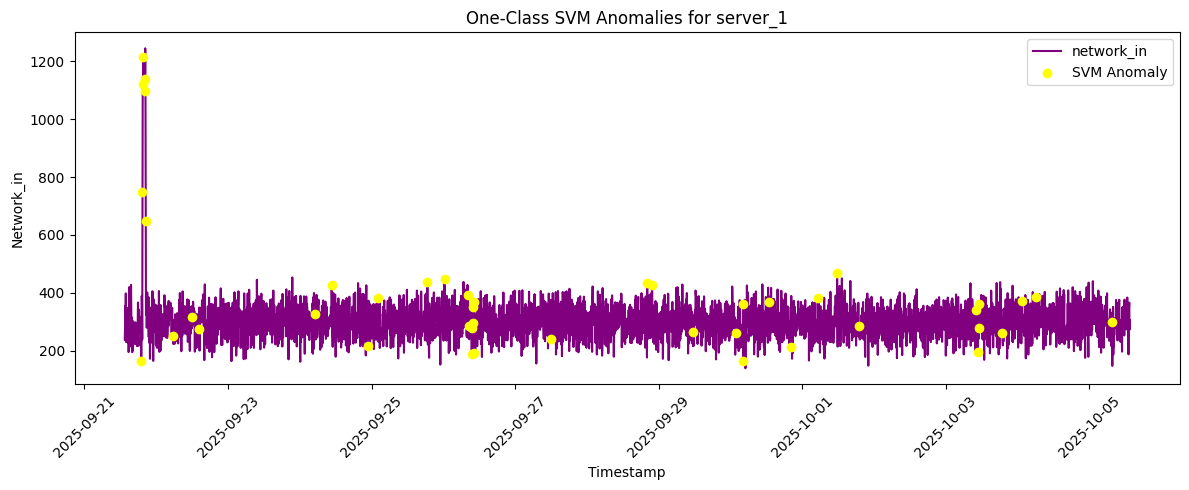

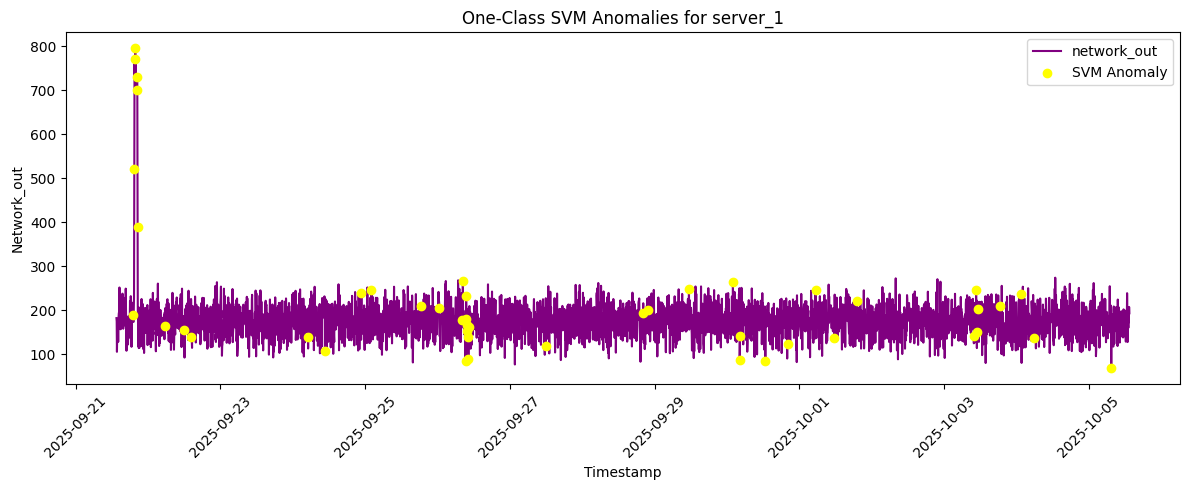

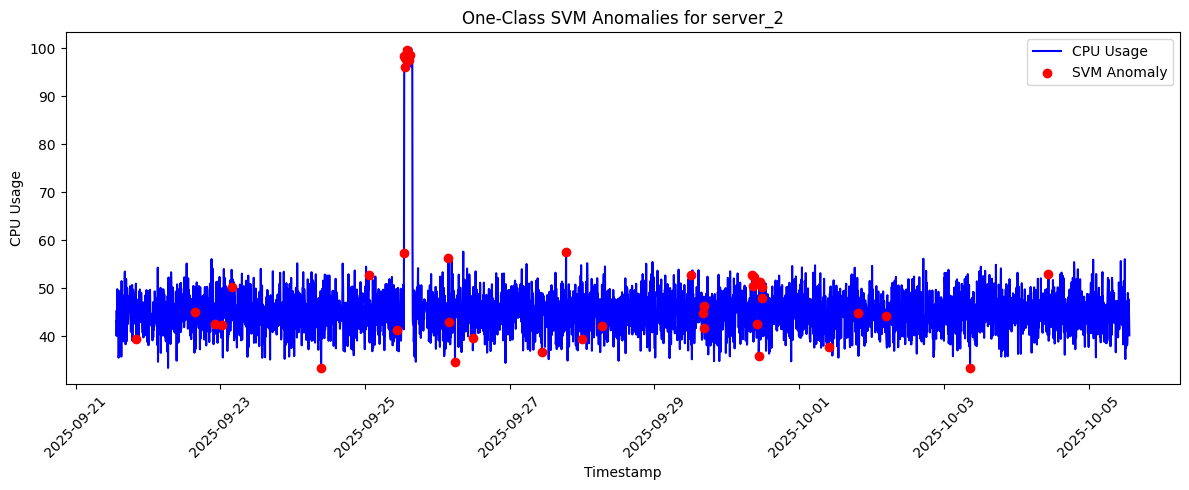

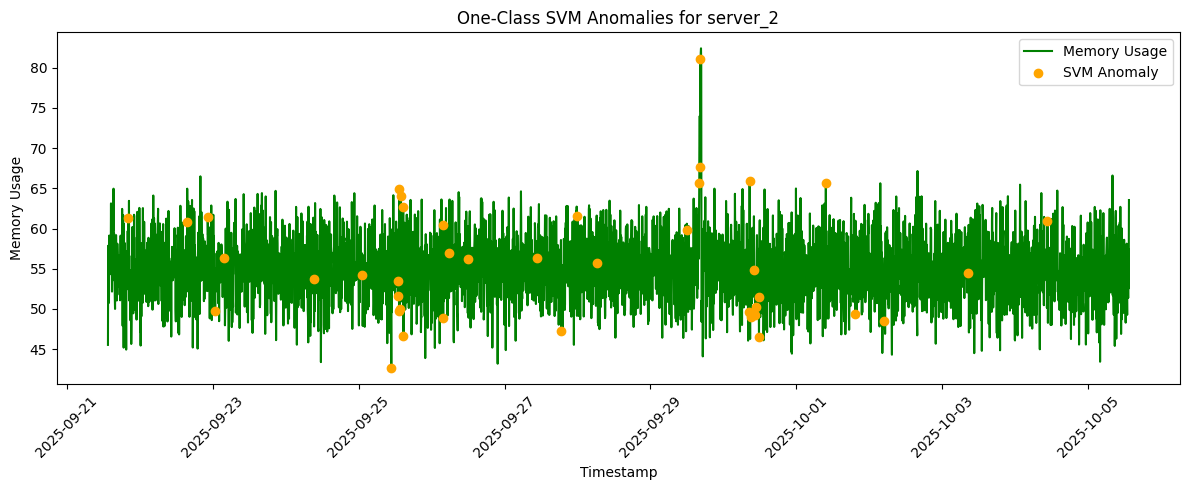

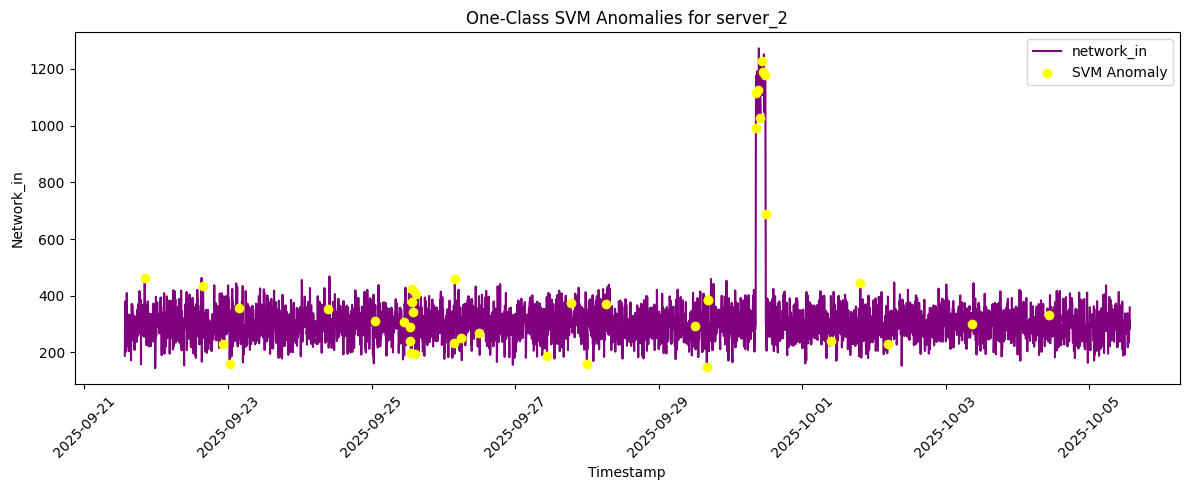

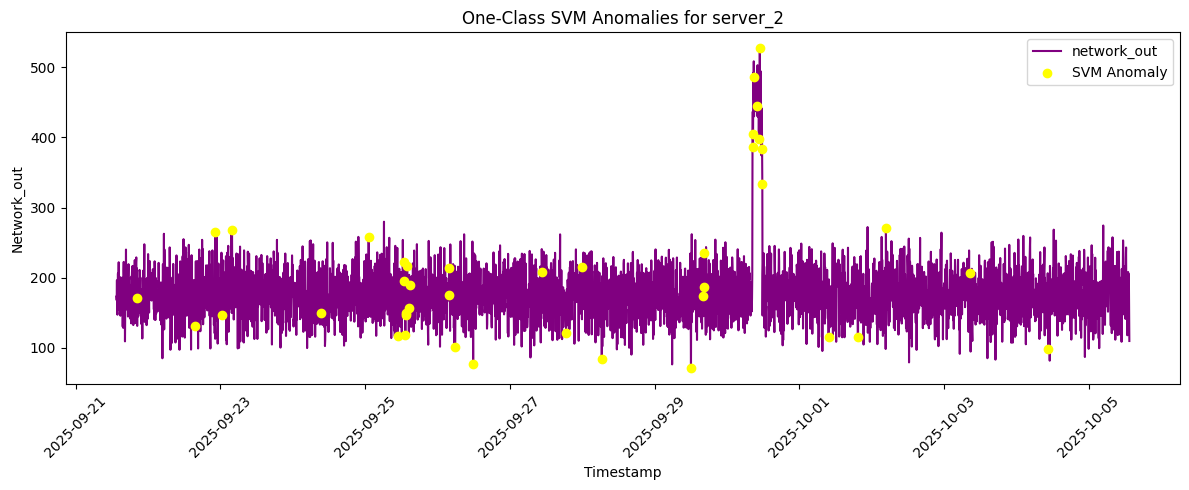

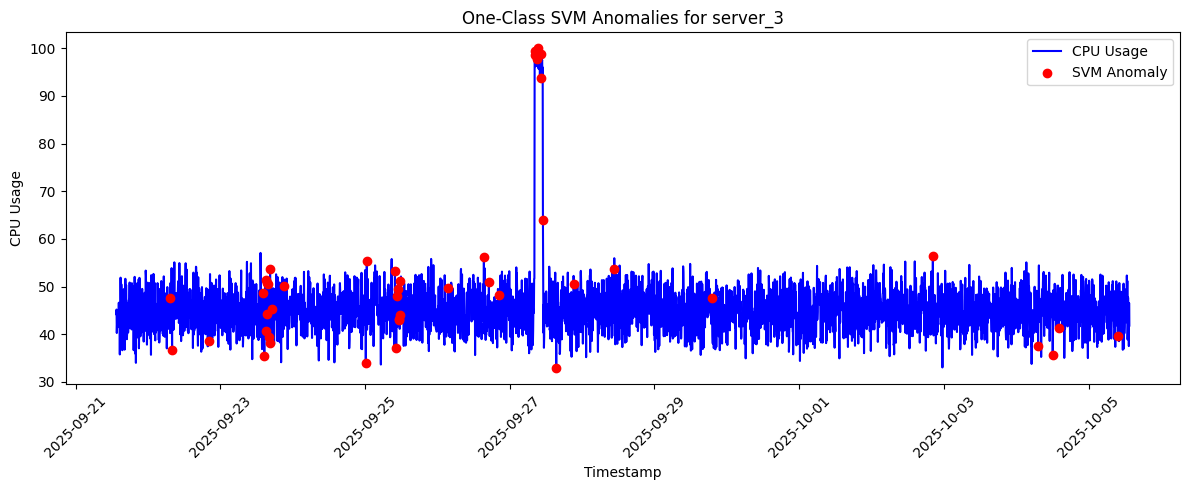

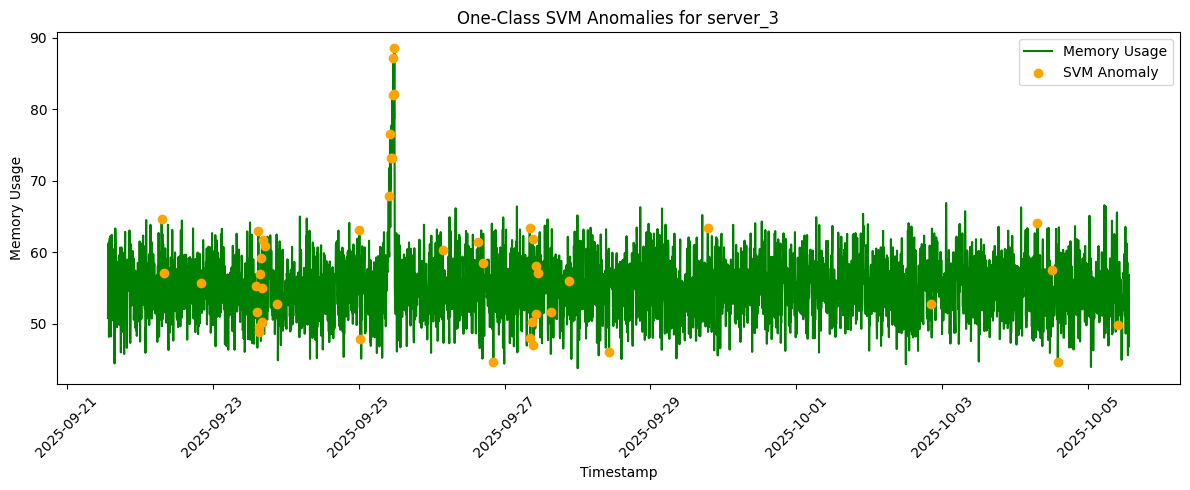

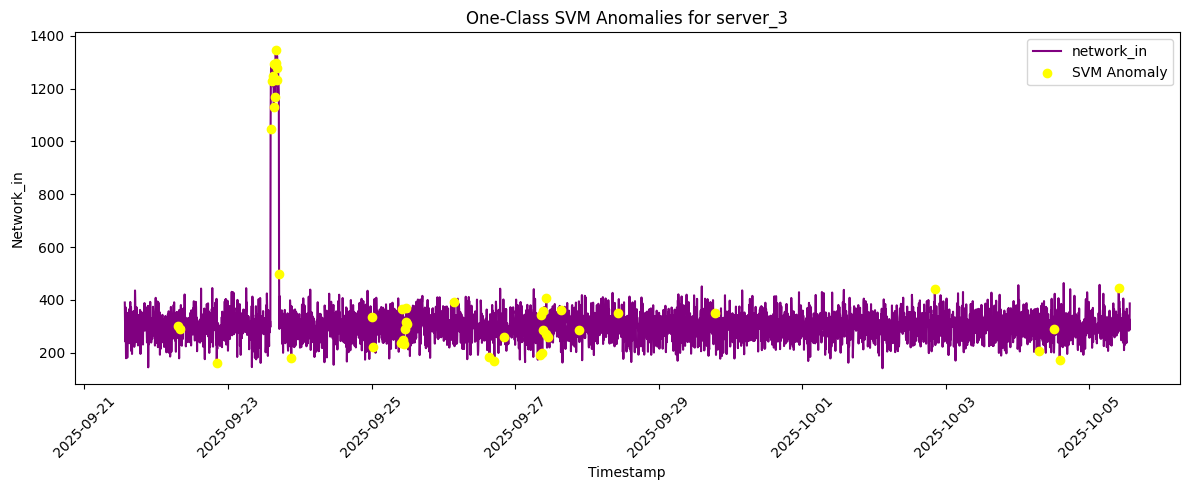

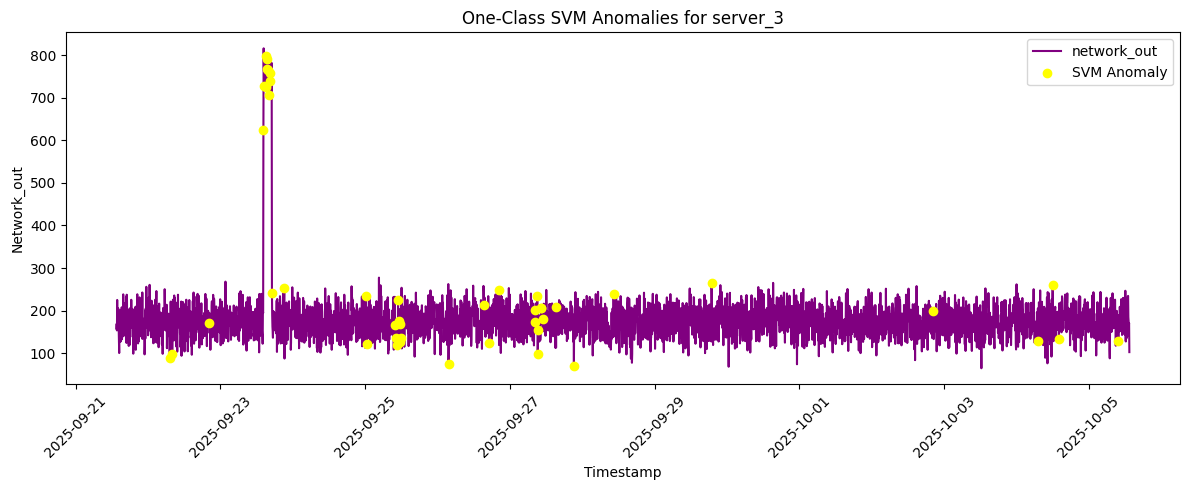

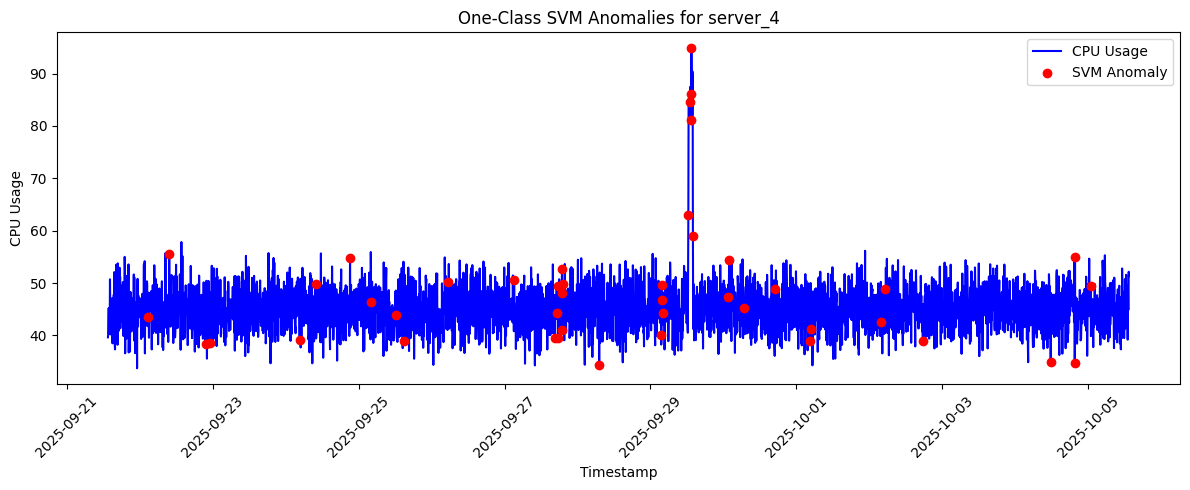

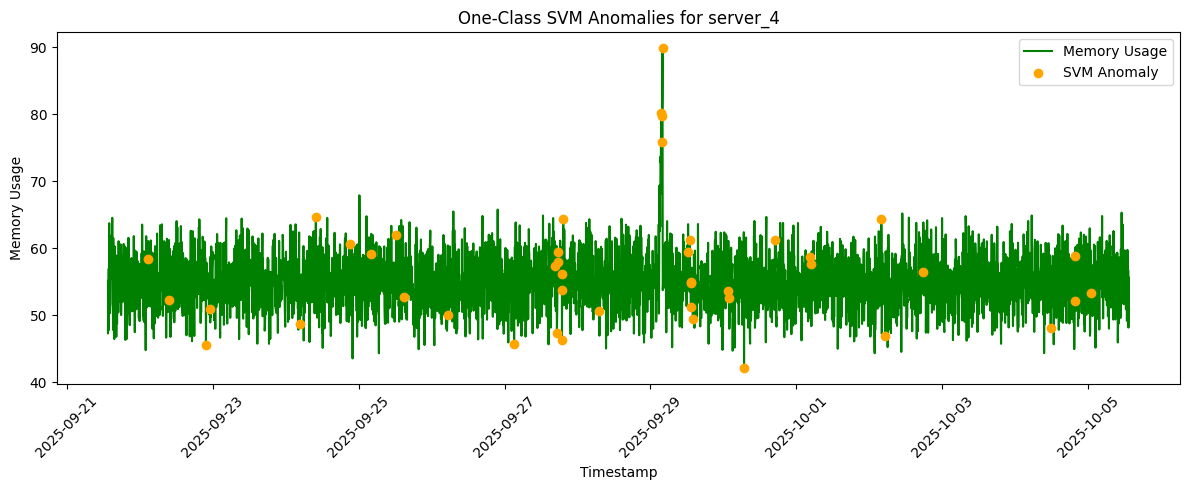

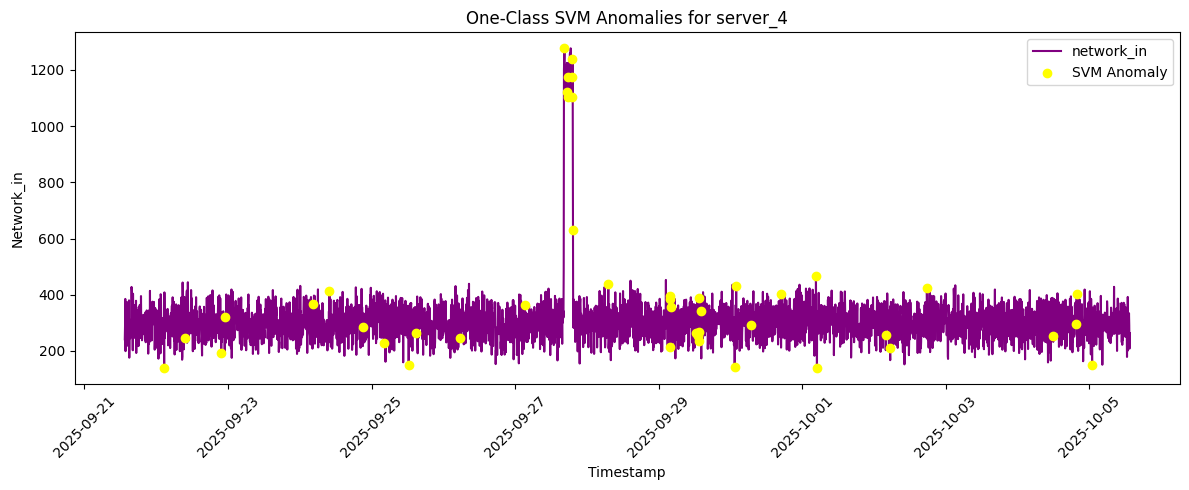

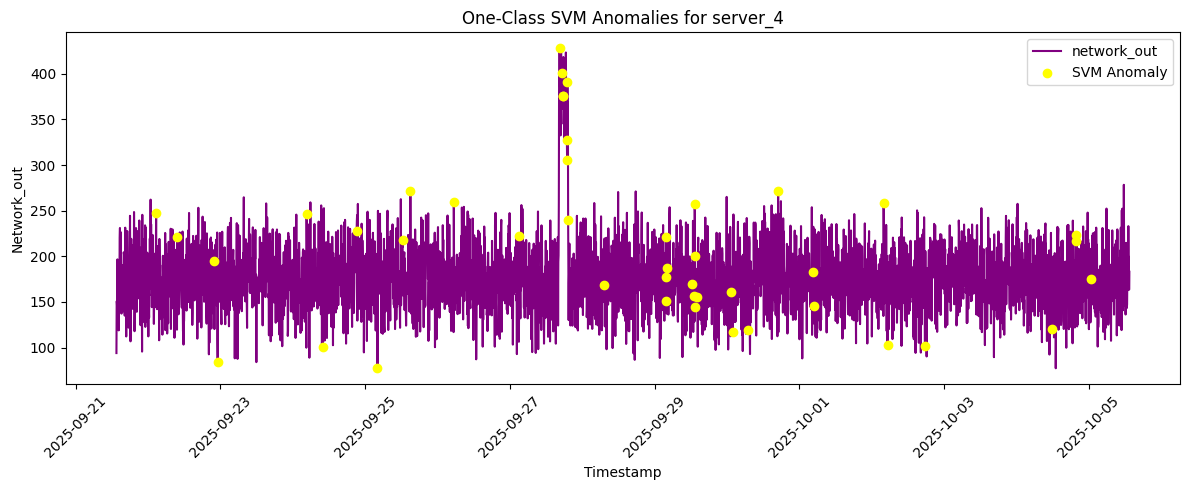

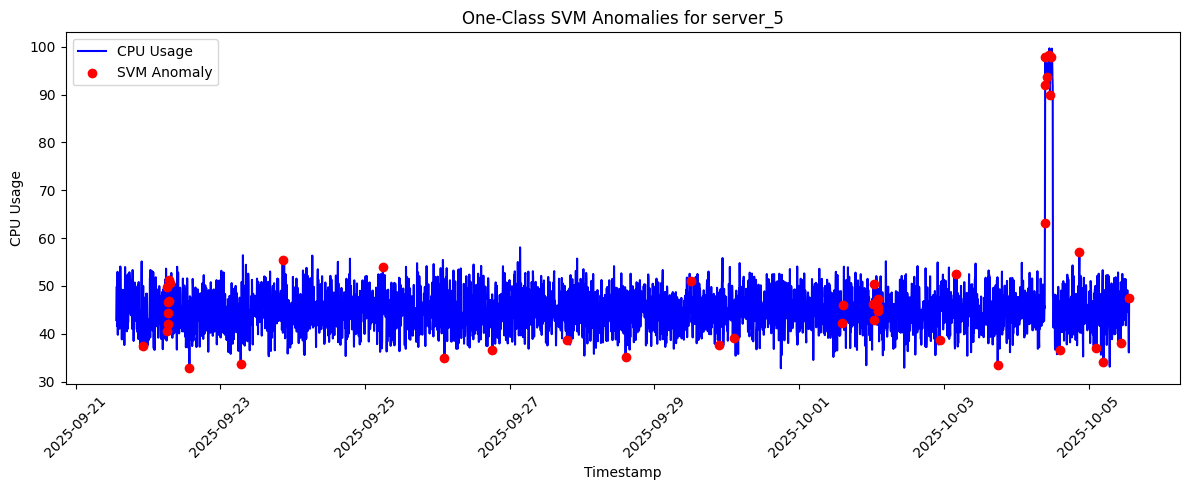

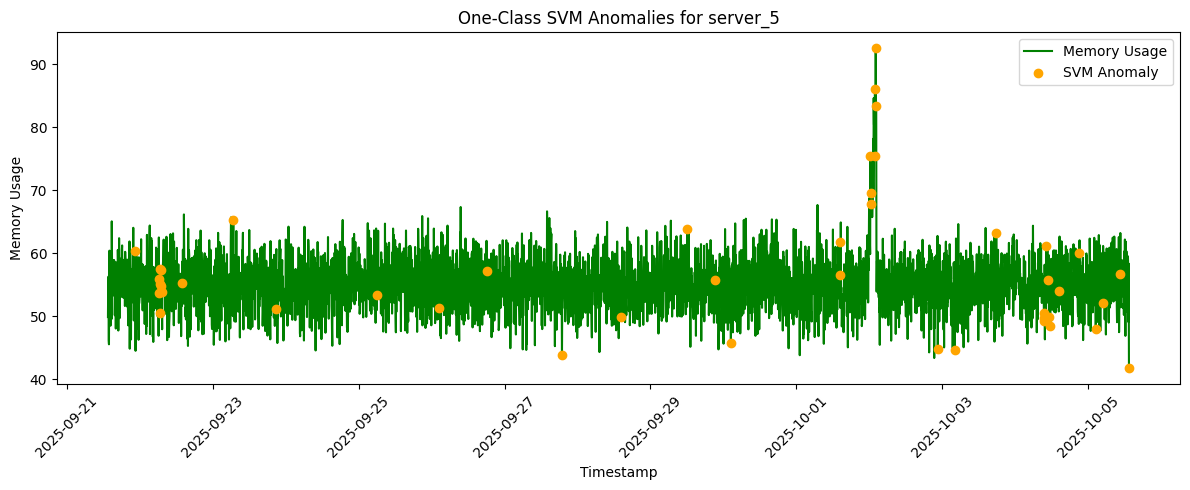

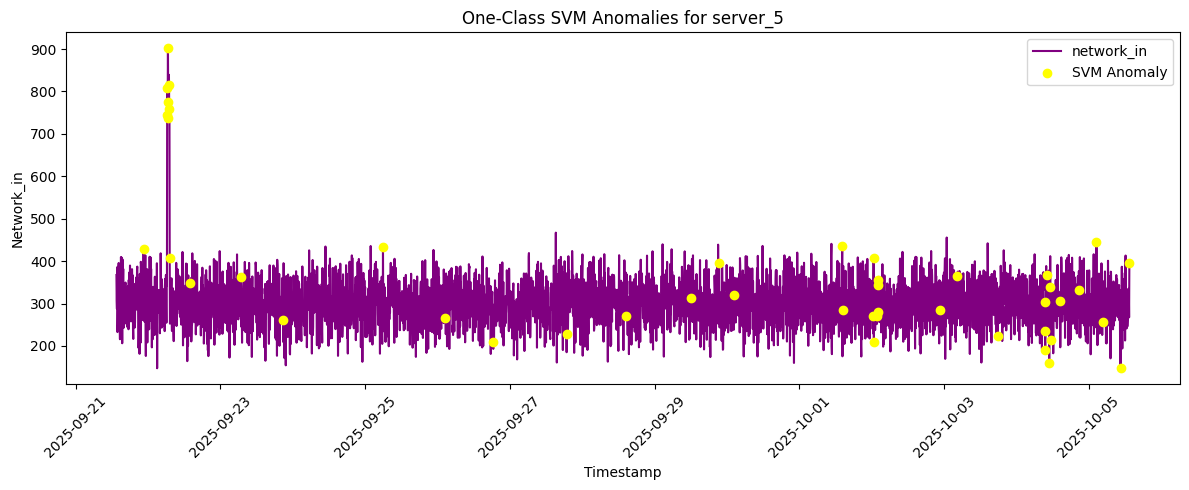

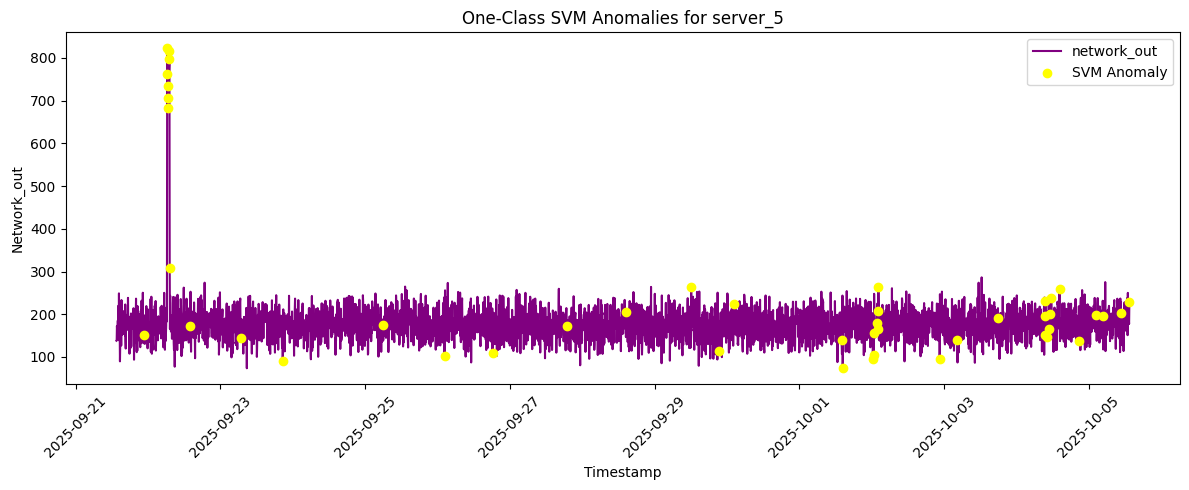

In [25]:
for server in resampled_df['server_id'].unique():
    data = resampled_df[resampled_df['server_id'] == server]
    svm_anomalies = data[data['svm_anomaly'] == -1]
    
    plt.figure(figsize=(12, 5))
    plt.plot(data['timestamp'], data['cpu_usage'], label='CPU Usage', color='blue')
    plt.scatter(svm_anomalies['timestamp'], svm_anomalies['cpu_usage'], color='red', label='SVM Anomaly', zorder=5)
    plt.title(f'One-Class SVM Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('CPU Usage')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 5))
    plt.plot(data['timestamp'], data['memory_usage'], label='Memory Usage', color='green')
    plt.scatter(svm_anomalies['timestamp'], svm_anomalies['memory_usage'], color='orange', label='SVM Anomaly', zorder=5)
    plt.title(f'One-Class SVM Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Memory Usage')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 5))
    plt.plot(data['timestamp'], data['network_in'], label='network_in', color='purple')
    plt.scatter(svm_anomalies['timestamp'], svm_anomalies['network_in'], color='yellow', label='SVM Anomaly', zorder=5)
    plt.title(f'One-Class SVM Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Network_in')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 5))
    plt.plot(data['timestamp'], data['network_out'], label='network_out', color='purple')
    plt.scatter(svm_anomalies['timestamp'], svm_anomalies['network_out'], color='yellow', label='SVM Anomaly', zorder=5)
    plt.title(f'One-Class SVM Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Network_out')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
resampled_df['is_anomaly'] = 1
resampled_df.loc[(resampled_df['cpu_usage'] > 90), 'is_anomaly'] = -1   # sustained CPU spike
resampled_df.loc[(resampled_df['memory_usage'] > 10), 'is_anomaly'] = -1
resampled_df.loc[(resampled_df['network_in'] > 10000), 'is_anomaly'] = -1
resampled_df.loc[(resampled_df['network_out'] > 10000), 'is_anomaly'] = -1

print("Isolation Forest:")
print(classification_report(resampled_df['is_anomaly'], resampled_df['anomaly']))

print("One-Class SVM:")
print(classification_report(resampled_df['is_anomaly'], resampled_df['svm_anomaly']))

Isolation Forest:
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02     20165
           1       0.00      0.00      0.00         0

    accuracy                           0.01     20165
   macro avg       0.50      0.01      0.01     20165
weighted avg       1.00      0.01      0.02     20165

One-Class SVM:
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02     20165
           1       0.00      0.00      0.00         0

    accuracy                           0.01     20165
   macro avg       0.50      0.01      0.01     20165
weighted avg       1.00      0.01      0.02     20165



C:\Users\vedant\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vedant\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vedant\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vedant\anaconda3\Lib\site-packages\sklearn\metrics\_

In [34]:
print("Ground Truth Labels:")
print(resampled_df['is_anomaly'].value_counts())

print("\nIsolation Forest Predictions:")
print(resampled_df['anomaly'].value_counts())

print("\nOne-Class SVM Predictions:")
print(resampled_df['svm_anomaly'].value_counts())

Ground Truth Labels:
is_anomaly
-1    20165
Name: count, dtype: int64

Isolation Forest Predictions:
anomaly
 1    19960
-1      205
Name: count, dtype: int64

One-Class SVM Predictions:
svm_anomaly
 1    19943
-1      222
Name: count, dtype: int64
